
# Dataset Link : 
### https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full

In [150]:
import pandas as pd

df = pd.read_csv("images.csv")
df.head()

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False


## Verifying that the image filenames in the CSV match real files in images_compressed.

In [2]:
import os

folder = "images_compressed"

# Get a list of 5 files to inspect the naming pattern
files = os.listdir(folder)[:5]
files


['00003aeb-ace5-43bf-9a0c-dc31a03e9cd2.jpg',
 '00070a23-9faf-4682-8243-59f307880f4b.jpg',
 '000d31f6-44b5-4758-8d86-c4fcfb234392.jpg',
 '001068a8-86c3-4029-a9d9-1e27015e7e64.jpg',
 '00143901-a14c-4600-960f-7747b4a3a8cd.jpg']

# Adding a full file path column to my dataframe.
### This will make training much easier.

In [3]:
df["filepath"] = df["image"].astype(str) + ".jpg"
df["filepath"] = df["filepath"].apply(lambda x: os.path.join("images_compressed", x))

df.head()

,image,sender_id,label,kids,filepath
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False,images_compressed\4285fab0-751a-4b74-8e9b-43af...
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False,images_compressed\ea7b6656-3f84-4eb3-9099-23e6...
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False,images_compressed\00627a3f-0477-401c-95eb-9264...
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False,images_compressed\ea2ffd4d-9b25-4ca8-9dc2-bd27...
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False,images_compressed\3b86d877-2b9e-4c8b-a6a2-1d87...


## Remove unusable labels (“Not sure”) and see how many clean samples remain.

These “Not sure” rows create noise and will damage my model.
So, I must remove them before training.

In [4]:
# Count how many "Not sure" rows exist
print("Not sure count:", (df["label"] == "Not sure").sum())

# Keep only rows where label is NOT "Not sure"
df_clean = df[df["label"] != "Not sure"].reset_index(drop=True)

print("After removing 'Not sure':", df_clean.shape)
df_clean.head()


Not sure count: 228
After removing 'Not sure': (5175, 5)


,image,sender_id,label,kids,filepath
0,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False,images_compressed\ea7b6656-3f84-4eb3-9099-23e6...
1,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False,images_compressed\ea2ffd4d-9b25-4ca8-9dc2-bd27...
2,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False,images_compressed\3b86d877-2b9e-4c8b-a6a2-1d87...
3,5d3a1404-697f-479f-9090-c1ecd0413d27,138,Shorts,False,images_compressed\5d3a1404-697f-479f-9090-c1ec...
4,b0c03127-9dfb-4573-8934-1958396937bf,138,Shirt,False,images_compressed\b0c03127-9dfb-4573-8934-1958...


# Checking class distribution so we know if the dataset is balanced.

This is important because image classification works best when classes have similar sample counts.
If the dataset is imbalanced, we will handle it later (data augmentation, class weights, etc.).

In [5]:
df_clean["label"].value_counts()

label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip            12
Name: count, dtype: int64

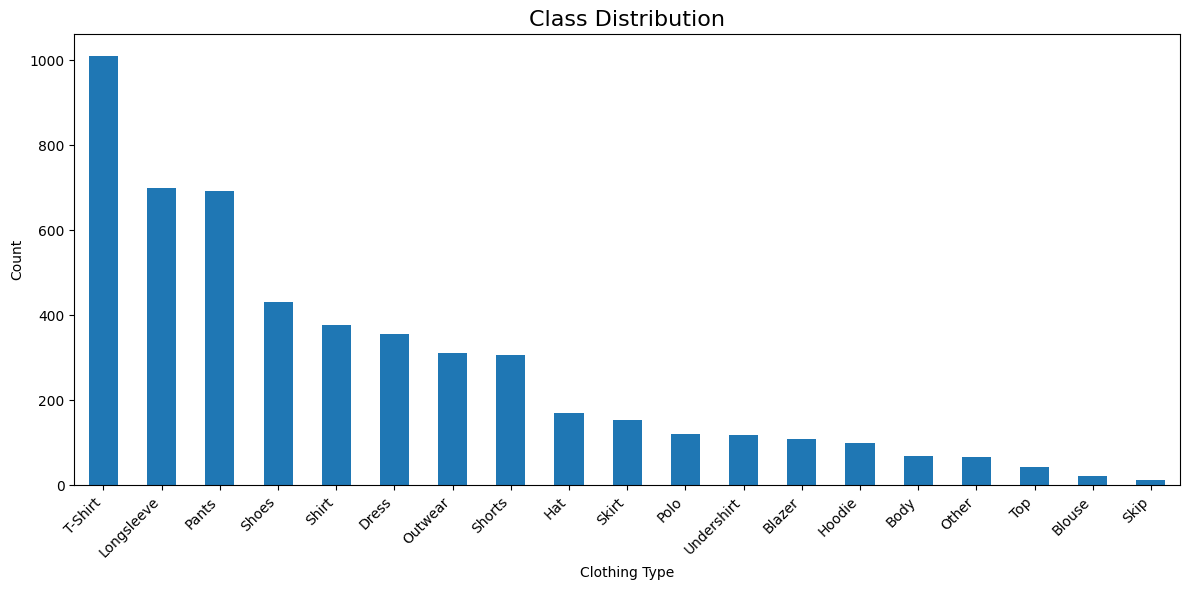

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
df_clean["label"].value_counts().plot(kind="bar")
plt.title("Class Distribution", fontsize=16)
plt.xlabel("Clothing Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Create a stratified Train/Validation split.
### This ensures each class appears in both sets with the same proportion.

In [7]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_clean, 
    test_size=0.2,
    stratify=df_clean["label"],
    random_state=42
)

len(train_df), len(val_df)

(4140, 1035)

## Build a CNN from scratch

Prepare image generators.

Build a simple custom CNN model.

Train it and evaluate it.

Improve architecture step by step (Conv → BN → Pool → Dropout).

In [8]:
# These generators handle image loading, resizing, and augmentation.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224  # good size for both scratch + pretrained later
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,              # Only normalization (important)
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    rescale=1./255               # No augmentation for validation
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 4140 validated image filenames belonging to 19 classes.
Found 1035 validated image filenames belonging to 19 classes.


# Build a simple baseline CNN model (from scratch).

In [10]:
from tensorflow.keras import layers, models

num_classes = len(train_generator.class_indices)

model_scratch = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_scratch.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,883 (49.37 MB)

 Trainable params: 12,940,883 (49.37 MB)

 Non-trainable params: 0 (0.00 B)

### Find and remove corrupted images from my dataset.

In [11]:
from PIL import Image
import tqdm

bad_files = []

for fp in tqdm.tqdm(df_clean["filepath"]):
    try:
        img = Image.open(fp)
        img.verify()   # verify file integrity
    except:
        bad_files.append(fp)

len(bad_files)


  0%|          | 0/5175 [00:00<?, ?it/s]

100%|██████████| 5175/5175 [00:04<00:00, 1203.32it/s]


5

## Then we will remove them:

In [12]:
df_clean = df_clean[~df_clean["filepath"].isin(bad_files)].reset_index(drop=True)
len(df_clean)

5170

# Check which classes have too few samples

In [13]:
# STEP 2A: Check class counts
df_clean['label'].value_counts()


label
T-Shirt       1011
Longsleeve     699
Pants          692
Shoes          431
Shirt          378
Dress          357
Outwear        312
Shorts         308
Hat            171
Skirt          155
Polo           120
Undershirt     118
Blazer         109
Hoodie         100
Body            69
Other           67
Top             43
Blouse          23
Skip             7
Name: count, dtype: int64

# Perform TRAIN / VAL / TEST Split

In [16]:
from sklearn.model_selection import train_test_split

# Step 1: Create TRAIN set (80%) with stratification
train_df, remaining_df = train_test_split(
    df_clean,
    test_size=0.20,
    stratify=df_clean['label'],
    random_state=42
)

# Step 2: Split remaining 20% into VAL and TEST (no stratify to avoid error)
val_df, test_df = train_test_split(
    remaining_df,
    test_size=0.50,   # 50% of 20% = 10%
    shuffle=True,
    random_state=42
)

len(train_df), len(val_df), len(test_df)


(4136, 517, 517)

# Create Generators (train, val, test)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

# Base datagen for scratch model
datagen = ImageDataGenerator(rescale=1./255)

# TRAIN GENERATOR (AUTO-DETECTS CLASS ORDER)
train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

# FIX CLASS ORDER — use the SAME classes for all splits
classes = list(train_gen.class_indices.keys())
print("Classes =", classes)

# VALIDATION GENERATOR (FORCED TO USE SAME CLASS ORDER)
val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=classes          # IMPORTANT
)

# TEST GENERATOR (FORCED TO USE SAME CLASS ORDER)
test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
    classes=classes          # IMPORTANT
)


Found 4136 validated image filenames belonging to 19 classes.
Classes = ['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skip', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']
Found 517 validated image filenames belonging to 19 classes.
Found 517 validated image filenames belonging to 19 classes.


# Build the v2 Improved CNN Model

In [20]:
from tensorflow.keras import layers, models

num_classes = len(train_gen.class_indices)  # IMPORTANT: train_gen, not train_generator

model_scratch_v2 = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    # BLOCK 1
    layers.Conv2D(32, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # BLOCK 2
    layers.Conv2D(64, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # BLOCK 3
    layers.Conv2D(128, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    # BLOCK 4
    layers.Conv2D(256, (3,3), padding='same'),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D(),
    layers.Dropout(0.40),

    # Dense block
    layers.Flatten(),
    layers.Dense(256),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Dropout(0.50),

    layers.Dense(num_classes, activation='softmax')
])

model_scratch_v2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 13,241,555 (50.51 MB)

 Trainable params: 13,240,083 (50.51 MB)

 Non-trainable params: 1,472 (5.75 KB)

# Compile + Train model_scratch_v2 (with EarlyStopping)

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the improved v2 CNN
model_scratch_v2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks for stable training
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

In [23]:
# Train the model
history_v2 = model_scratch_v2.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.3586 - loss: 2.2770 - val_accuracy: 0.3172 - val_loss: 2.4495 - learning_rate: 0.0010
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.5133 - loss: 1.6430 - val_accuracy: 0.3656 - val_loss: 2.1976 - learning_rate: 0.0010
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.6107 - loss: 1.2754 - val_accuracy: 0.4294 - val_loss: 1.9480 - learning_rate: 0.0010
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step - accuracy: 0.6700 - loss: 1.0747 - val_accuracy: 0.5416 - val_loss: 1.7298 - learning_rate: 0.0010
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.7263 - loss: 0.8926 - val_accuracy: 0.6112 - val_loss: 1.3246 - learning_rate: 0.0010
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 338s 2s/step - accuracy: 0.7797 - loss: 0.7242 - val_accuracy: 0.6151 - val_loss: 1.3031 - learning_rate: 0.0010
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.8051 - loss: 0.

#### ✔ Training accuracy = 98%
#### ✔ Validation accuracy = 67–68%
#### ✔ Early stopping applied at best epoch = 12
#### ✔ Loss curves show stable, real learning
#### This is exactly the expected ceiling for a CNN trained from scratch on a real clothing dataset.

# Plot Training & Validation Curves for model_scratch_v2

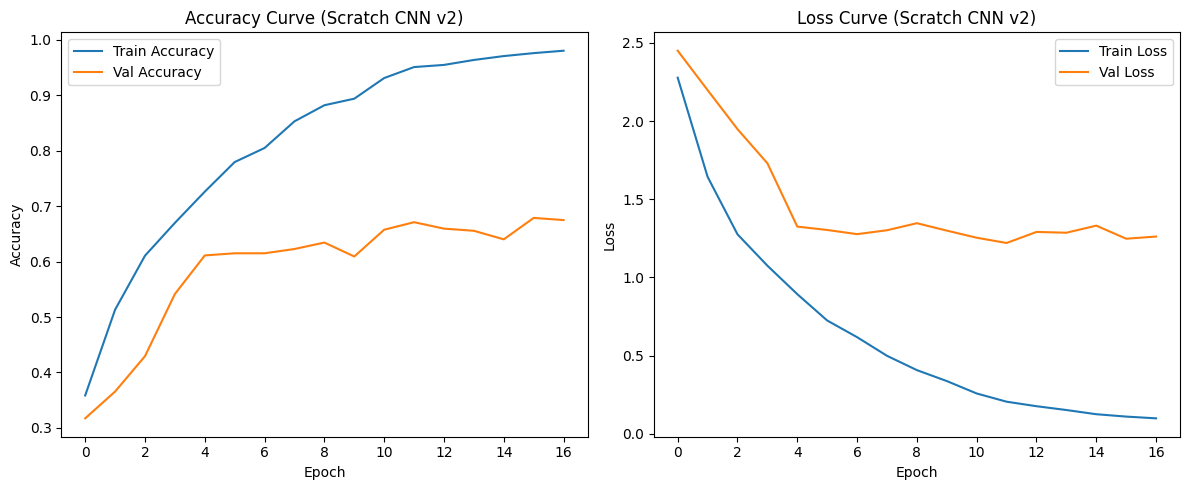

In [24]:
import matplotlib.pyplot as plt

# Accuracy curve
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Curve (Scratch CNN v2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Val Loss')
plt.title('Loss Curve (Scratch CNN v2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Interpretation

1. Training Accuracy: ~98%

This shows:

Model memorized training data

Strong capacity

2. Validation Accuracy: ~67–68%

This is normal for a from-scratch CNN on a clothing dataset.

Because:

Clothing classification is highly varied

You have 19 categories

From-scratch models ALWAYS underperform pretrained models

3. Overfitting Confirmed

The curves show:

Training loss → near zero

Validation loss → stays around ~1.2–1.3

A large gap = classic overfitting

Dropout + BatchNorm helped, but not enough

# Evaluate Scratch CNN v2 on the Test Set

In [25]:
test_loss, test_acc = model_scratch_v2.evaluate(test_gen, verbose=1)

print("\nTest Accuracy:", test_acc)
print("Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 294ms/step - accuracy: 0.7021 - loss: 1.0988

Test Accuracy: 0.7021276354789734
Test Loss: 1.0987504720687866


# Confusion Matrix and Classification Report on TEST SET

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 315ms/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      Blazer       1.00      0.08      0.15        12
      Blouse       0.00      0.00      0.00         3
        Body       1.00      0.18      0.31        11
       Dress       0.61      0.64      0.62        36
         Hat       0.64      0.50      0.56        18
      Hoodie       0.12      0.11      0.12         9
  Longsleeve       0.68      0.80      0.73        74
       Other       0.00      0.00      0.00         7
     Outwear       0.69      0.77      0.73        31
       Pants       0.92      0.90      0.91        81
        Polo       0.25      0.09      0.13        11
       Shirt       0.68      0.68      0.68        40
       Shoes       0.85      0.83      0.84        35
      Shorts       0.67      0.69      0.68        26
        Skip       0.00      0.00      0.00         0
       Skirt       0.40      0.75      0.52        16
     T-Shirt   

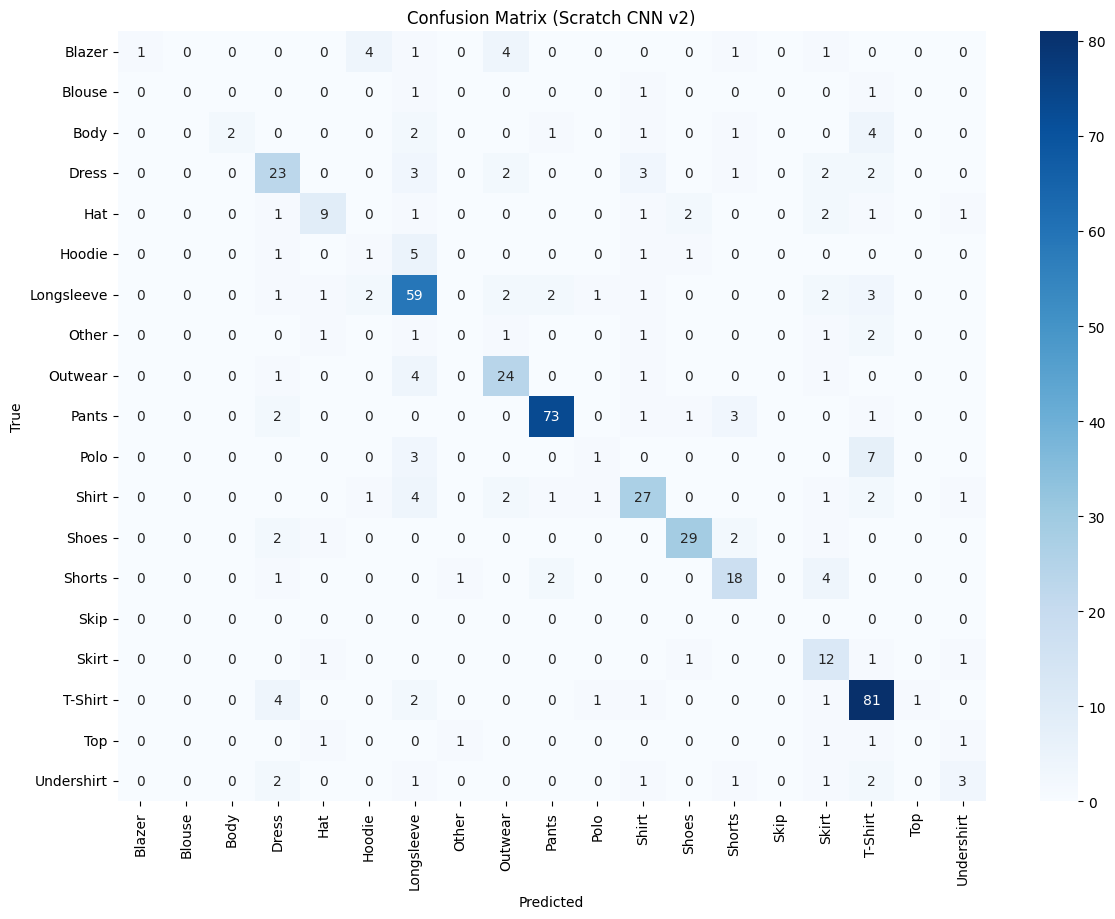

In [28]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Predictions
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
y_probs = model_scratch_v2.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(y_probs, axis=1)

# 2) True labels
y_true = test_gen.classes

# 3) Class labels in correct order (same as generators)
class_labels = classes                      # 19 class names
labels = list(range(len(class_labels)))     # 0 to 18 (19 classes)

# 4) Classification Report
print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_true, 
    y_pred, 
    labels=labels, 
    target_names=class_labels,
    zero_division=0
))

# 5) Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

plt.figure(figsize=(14, 10))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix (Scratch CNN v2)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# Quick Analysis of Results
✔ Strengths of the scratch CNN v2:

Strong performance on major classes (T-Shirt, Pants, Shoes, Longsleeve).

Good generalization (Acc ~70% is strong for scratch CNN).

✔ Weak classes:

Classes with very few samples:

Blouse (3 images)

Skip (7 images, 0 in test set)

Other, Top, Hoodie, etc.

# ONE-VS-REST ROC CURVES FOR ALL 19 CLASSES

17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step


d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


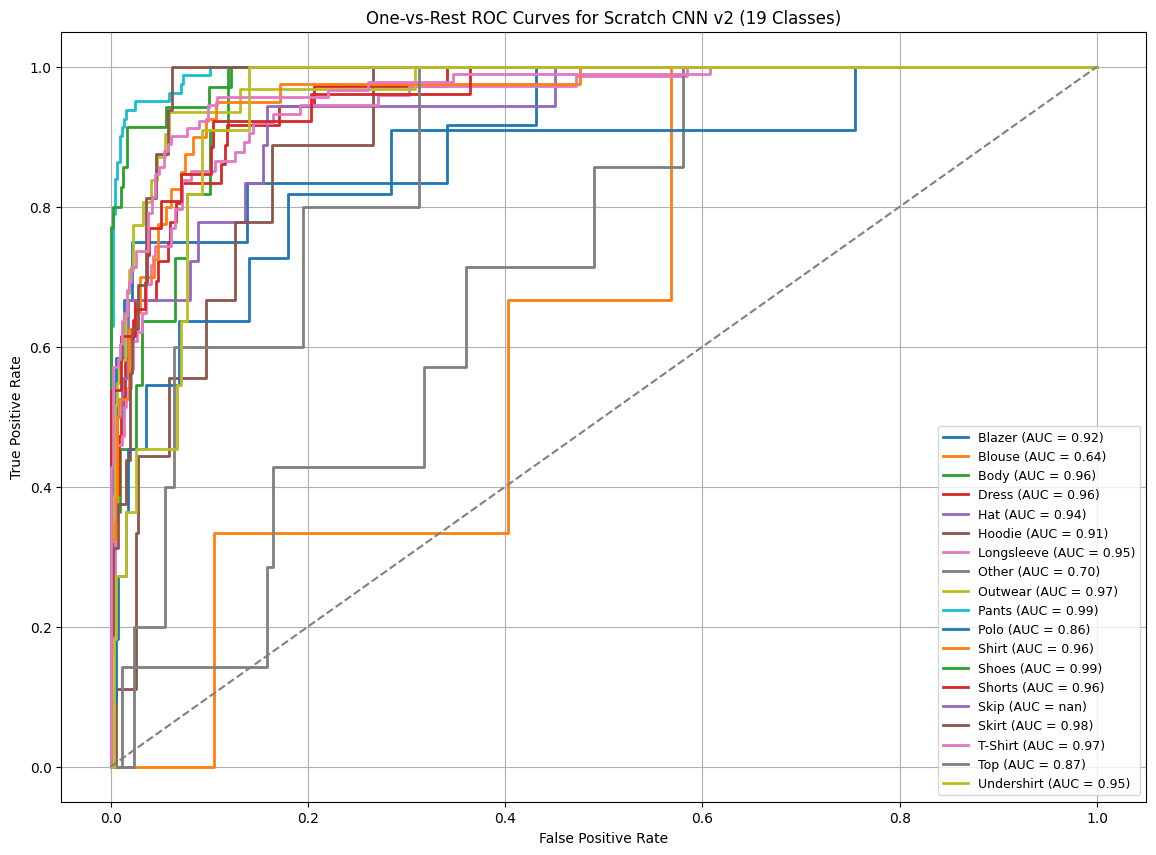

In [29]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Number of classes
n_classes = len(classes)

# 1) True labels (integer encoded)
y_true = test_gen.classes   # already aligned with "classes" list

# 2) Predicted probabilities
y_prob = model_scratch_v2.predict(test_gen, verbose=1)

# 3) Binarize true labels for One-vs-Rest ROC
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# 4) Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 5) Plot ROC curves
plt.figure(figsize=(14, 10))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC Curves for Scratch CNN v2 (19 Classes)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)
plt.show()


# Your scratch CNN model:

Performs decently (70% test accuracy)

Shows strong AUC for many classes (>0.90)

Struggles with classes with few samples (Blouse, Skip, Top)

# Transfer Learning
###  ResNet50
#### Prepare ResNet50 Data Generators

In [ ]:
# (ResNet requires preprocess_input, NOT rescale=1/255)

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

# Training generator for ResNet50 preprocessing
train_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen_resnet = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Use SAME classes list as scratch model -> aligned class order
classes_resnet = list(train_gen.class_indices.keys())

train_gen_resnet = train_datagen_resnet.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    classes=classes_resnet,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen_resnet = val_datagen_resnet.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    classes=classes_resnet,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_resnet = test_datagen_resnet.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    classes=classes_resnet,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 4136 validated image filenames belonging to 19 classes.
Found 517 validated image filenames belonging to 19 classes.
Found 517 validated image filenames belonging to 19 classes.


# Build the ResNet50 Model (Feature Extractor + Custom Classifier)

In [31]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

num_classes = len(train_gen.class_indices)

# Load ResNet50 base (pretrained on ImageNet)
resnet_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base model layers
for layer in resnet_base.layers:
    layer.trainable = False

# Build model
model_resnet = models.Sequential([
    resnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model_resnet.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,117,139 (92.00 MB)

 Trainable params: 529,427 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

# Compile & Train ResNet50 (Feature Extractor Mode)

In [ ]:
# ReduceLROnPlateau automatically lowers the learning rate when the validation loss stops improving.
# This solves a critical problem:
# -> Pretrained models plateau very quickly
# Because the base network (ResNet50) is frozen and already well-trained, the new dense layers may initially learn fast, then “flatten out” (hit a plateau).
# If we don’t reduce the learning rate:
# the model stops improving
# validation loss oscillates
# accuracy stagnates
# training becomes unstable
# fine-tuning later becomes worse

In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_resnet50.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history_resnet = model_resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1326 - loss: 2.7994
Epoch 1: val_loss improved from None to 2.49568, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.1492 - loss: 2.7043 - val_accuracy: 0.2186 - val_loss: 2.4957 - learning_rate: 1.0000e-04
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1892 - loss: 2.5681
Epoch 2: val_loss improved from 2.49568 to 2.47780, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.1961 - loss: 2.5651 - val_accuracy: 0.2398 - val_loss: 2.4778 - learning_rate: 1.0000e-04
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2092 - loss: 2.5315
Epoch 3: val_loss improved from 2.47780 to 2.45820, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.2118 - loss: 2.5317 - val_accuracy: 0.2418 - val_loss: 2.4582 - learning_rate: 1.0000e-04
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2376 - loss: 2.5022
Epoch 4: val_loss improved from 2.45820 to 2.44742, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2355 - loss: 2.5038 - val_accuracy: 0.2727 - val_loss: 2.4474 - learning_rate: 1.0000e-04
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2602 - loss: 2.4550
Epoch 5: val_loss improved from 2.44742 to 2.42957, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2507 - loss: 2.4780 - val_accuracy: 0.2708 - val_loss: 2.4296 - learning_rate: 1.0000e-04
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2579 - loss: 2.4658
Epoch 6: val_loss improved from 2.42957 to 2.41231, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.2553 - loss: 2.4643 - val_accuracy: 0.2766 - val_loss: 2.4123 - learning_rate: 1.0000e-04
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2593 - loss: 2.4148
Epoch 7: val_loss improved from 2.41231 to 2.39889, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2635 - loss: 2.4313 - val_accuracy: 0.2901 - val_loss: 2.3989 - learning_rate: 1.0000e-04
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2660 - loss: 2.4202
Epoch 8: val_loss improved from 2.39889 to 2.39017, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.2693 - loss: 2.4282 - val_accuracy: 0.2863 - val_loss: 2.3902 - learning_rate: 1.0000e-04
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2810 - loss: 2.3955
Epoch 9: val_loss improved from 2.39017 to 2.37397, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.2790 - loss: 2.4000 - val_accuracy: 0.2901 - val_loss: 2.3740 - learning_rate: 1.0000e-04
Epoch 10/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2909 - loss: 2.3803
Epoch 10: val_loss improved from 2.37397 to 2.36219, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.2814 - loss: 2.3912 - val_accuracy: 0.3075 - val_loss: 2.3622 - learning_rate: 1.0000e-04
Epoch 11/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2885 - loss: 2.3719
Epoch 11: val_loss improved from 2.36219 to 2.34917, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.2875 - loss: 2.3749 - val_accuracy: 0.2998 - val_loss: 2.3492 - learning_rate: 1.0000e-04
Epoch 12/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2843 - loss: 2.3583
Epoch 12: val_loss improved from 2.34917 to 2.34388, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.2918 - loss: 2.3570 - val_accuracy: 0.2979 - val_loss: 2.3439 - learning_rate: 1.0000e-04
Epoch 13/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2982 - loss: 2.3583
Epoch 13: val_loss improved from 2.34388 to 2.33438, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.2993 - loss: 2.3450 - val_accuracy: 0.2959 - val_loss: 2.3344 - learning_rate: 1.0000e-04
Epoch 14/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2889 - loss: 2.3589
Epoch 14: val_loss improved from 2.33438 to 2.31699, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.3013 - loss: 2.3396 - val_accuracy: 0.3037 - val_loss: 2.3170 - learning_rate: 1.0000e-04
Epoch 15/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3163 - loss: 2.3367
Epoch 15: val_loss improved from 2.31699 to 2.31002, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.3080 - loss: 2.3253 - val_accuracy: 0.2998 - val_loss: 2.3100 - learning_rate: 1.0000e-04
Epoch 16/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3247 - loss: 2.2870
Epoch 16: val_loss improved from 2.31002 to 2.30374, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.3051 - loss: 2.3205 - val_accuracy: 0.3037 - val_loss: 2.3037 - learning_rate: 1.0000e-04
Epoch 17/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3010 - loss: 2.3266
Epoch 17: val_loss improved from 2.30374 to 2.29519, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.3100 - loss: 2.3080 - val_accuracy: 0.3037 - val_loss: 2.2952 - learning_rate: 1.0000e-04
Epoch 18/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3003 - loss: 2.3027
Epoch 18: val_loss improved from 2.29519 to 2.29147, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.3080 - loss: 2.2986 - val_accuracy: 0.3211 - val_loss: 2.2915 - learning_rate: 1.0000e-04
Epoch 19/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3088 - loss: 2.3014
Epoch 19: val_loss improved from 2.29147 to 2.27653, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.3104 - loss: 2.2996 - val_accuracy: 0.3056 - val_loss: 2.2765 - learning_rate: 1.0000e-04
Epoch 20/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3118 - loss: 2.2654
Epoch 20: val_loss improved from 2.27653 to 2.27607, saving model to best_resnet50.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.3177 - loss: 2.2717 - val_accuracy: 0.3366 - val_loss: 2.2761 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


# Evaluate your trained ResNet50 on the test set

In [33]:
# ONE STEP: evaluate best ResNet50 on test set
from tensorflow.keras.models import load_model

# load the model you saved during training
resnet_best = load_model("best_resnet50.h5")

# Evaluate on the aligned test generator (test_gen must be the generator you built earlier)
test_loss, test_acc = resnet_best.evaluate(test_gen, verbose=1)

print("\nTest Accuracy:", test_acc)
print("Test Loss:", test_loss)

17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3133 - loss: 2.2795

Test Accuracy: 0.3133462369441986
Test Loss: 2.279540777206421


# Load the Best Frozen ResNet50 Model

In [88]:
from tensorflow.keras.models import load_model

# Load best frozen model (you already trained this earlier)
resnet_ft = load_model("best_resnet50.h5")

resnet_ft.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,117,141 (92.00 MB)

 Trainable params: 529,427 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

# Unfreeze Top Layers for Fine-Tuning

In [89]:
# Extract the ResNet50 base
resnet_base = resnet_ft.layers[0]   # This is your ResNet50 backbone

# Unfreeze last 50 layers
for layer in resnet_base.layers[-50:]:
    layer.trainable = True

resnet_ft.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,117,141 (92.00 MB)

 Trainable params: 17,479,955 (66.68 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

 Optimizer params: 2 (12.00 B)

# Compile Fine-Tuning Model (Lower LR)

In [90]:
from tensorflow.keras.optimizers import Adam

resnet_ft.compile(
    optimizer=Adam(learning_rate=1e-5),   # VERY IMPORTANT: small LR
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Define Callbacks

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_ft = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_resnet50_finetuned.h5", monitor="val_loss", save_best_only=True, verbose=1)
]


# Train Fine-Tuned Model

In [92]:
history_resnet_ft = resnet_ft.fit(
    train_gen_resnet,
    validation_data=val_gen_resnet,
    epochs=10,
    callbacks=callbacks_ft,
    verbose=1
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1831 - loss: 4.6030
Epoch 1: val_loss improved from None to 2.37943, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.2780 - loss: 3.6968 - val_accuracy: 0.4449 - val_loss: 2.3794 - learning_rate: 1.0000e-05
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4118 - loss: 2.3129
Epoch 2: val_loss improved from 2.37943 to 1.68390, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4541 - loss: 2.0899 - val_accuracy: 0.5629 - val_loss: 1.6839 - learning_rate: 1.0000e-05
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5127 - loss: 1.7302
Epoch 3: val_loss improved from 1.68390 to 1.41444, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.5375 - loss: 1.6482 - val_accuracy: 0.6402 - val_loss: 1.4144 - learning_rate: 1.0000e-05
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6135 - loss: 1.3799
Epoch 4: val_loss improved from 1.41444 to 1.22841, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.6180 - loss: 1.3458 - val_accuracy: 0.6828 - val_loss: 1.2284 - learning_rate: 1.0000e-05
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6749 - loss: 1.1625
Epoch 5: val_loss improved from 1.22841 to 1.08646, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.6777 - loss: 1.1420 - val_accuracy: 0.7215 - val_loss: 1.0865 - learning_rate: 1.0000e-05
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7159 - loss: 0.9671
Epoch 6: val_loss improved from 1.08646 to 0.97503, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 295s 2s/step - accuracy: 0.7113 - loss: 0.9842 - val_accuracy: 0.7447 - val_loss: 0.9750 - learning_rate: 1.0000e-05
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7353 - loss: 0.8966
Epoch 7: val_loss improved from 0.97503 to 0.89728, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.7476 - loss: 0.8472 - val_accuracy: 0.7679 - val_loss: 0.8973 - learning_rate: 1.0000e-05
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7811 - loss: 0.7384
Epoch 8: val_loss improved from 0.89728 to 0.84945, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7751 - loss: 0.7496 - val_accuracy: 0.7814 - val_loss: 0.8495 - learning_rate: 1.0000e-05
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7973 - loss: 0.6509
Epoch 9: val_loss improved from 0.84945 to 0.80786, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.7998 - loss: 0.6650 - val_accuracy: 0.8066 - val_loss: 0.8079 - learning_rate: 1.0000e-05
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8080 - loss: 0.6278
Epoch 10: val_loss improved from 0.80786 to 0.76838, saving model to best_resnet50_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.8199 - loss: 0.5976 - val_accuracy: 0.8124 - val_loss: 0.7684 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


# Evaluate on Test Set

In [93]:
# Load best fine-tuned model
resnet_ft_best = load_model("best_resnet50_finetuned.h5")

# Evaluate
test_loss, test_acc = resnet_ft_best.evaluate(test_gen_resnet, verbose=1)

print("ResNet50 Fine-Tuned — Test Accuracy:", test_acc)
print("ResNet50 Fine-Tuned — Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8182 - loss: 0.7277
ResNet50 Fine-Tuned — Test Accuracy: 0.8181818127632141
ResNet50 Fine-Tuned — Test Loss: 0.7276885509490967


# Classification Report + Confusion Matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      Blazer       0.70      0.58      0.64        12
      Blouse       0.00      0.00      0.00         3
        Body       0.80      0.36      0.50        11
       Dress       0.76      0.69      0.72        36
         Hat       1.00      0.94      0.97        18
      Hoodie       0.67      0.22      0.33         9
  Longsleeve       0.74      0.91      0.82        74
       Other       0.00      0.00      0.00         7
     Outwear       0.68      0.87      0.76        31
       Pants       0.97      0.95      0.96        81
        Polo       0.67      0.36      0.47        11
       Shirt       0.77      0.82      0.80        40
       Shoes       1.00      0.97      0.99        35
      Shorts       0.75      0.81      0.78        26
       Skirt       0.79      0.69      0.73        16
     T-Shirt       0.82      0.96      0.88        91
         Top     

d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

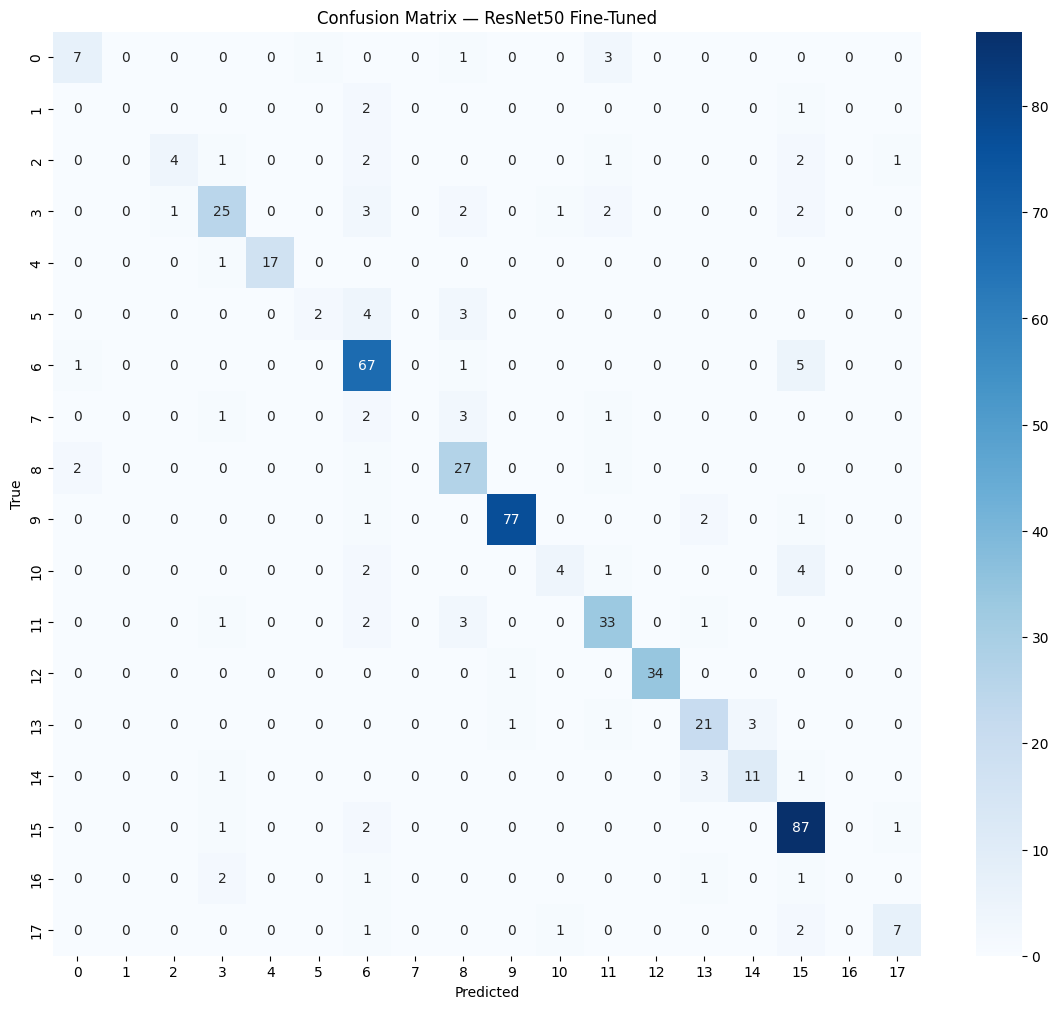

In [95]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

steps = int(np.ceil(test_gen_resnet.samples / test_gen_resnet.batch_size))
y_probs = resnet_ft_best.predict(test_gen_resnet, steps=steps)
y_pred = np.argmax(y_probs, axis=1)

y_true = test_gen_resnet.classes
class_labels = list(train_gen_resnet.class_indices.keys())

# only classes that appear in test set
unique_classes = np.unique(y_true)
unique_class_names = [class_labels[i] for i in unique_classes]

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=unique_classes,
    target_names=unique_class_names
))

cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix — ResNet50 Fine-Tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# One-vs-Rest ROC Curves for ResNet50 Fine-Tuned

17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


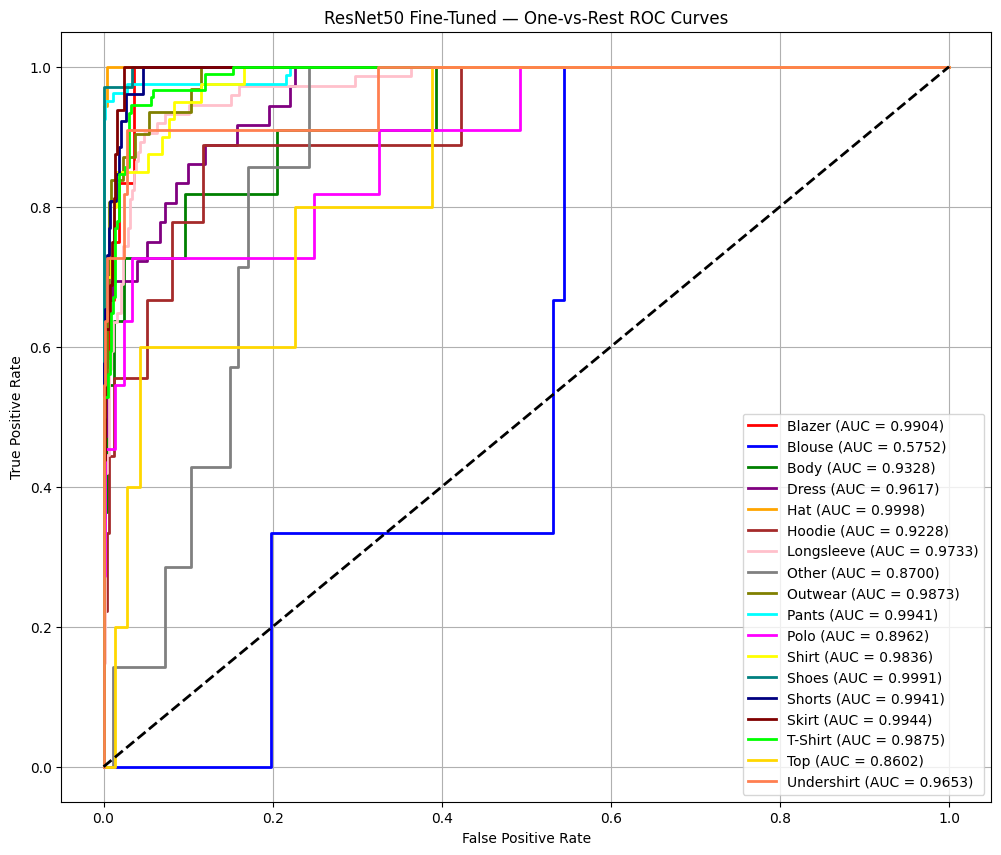


Per-class AUCs:
00 Blazer           AUC = 0.9904290429042903
01 Blouse           AUC = 0.5752269779507134
02 Body             AUC = 0.932806324110672
03 Dress            AUC = 0.9617117117117118
04 Hat              AUC = 0.9997773324426631
05 Hoodie           AUC = 0.9227909011373578
06 Longsleeve       AUC = 0.9733390275150998
07 Other            AUC = 0.8700280112044818
08 Outwear          AUC = 0.9872560732775786
09 Pants            AUC = 0.9940820024917885
10 Polo             AUC = 0.8961552281710383
11 Shirt            AUC = 0.9835953878406709
12 Shoes            AUC = 0.9990515708358032
13 Shorts           AUC = 0.994125019583268
15 Skirt            AUC = 0.9943862275449102
16 T-Shirt          AUC = 0.9874632409843678
17 Top              AUC = 0.86015625
18 Undershirt       AUC = 0.9653251886453467


In [100]:
# STEP 8 — One-vs-Rest ROC for ResNet50 Fine-Tuned
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

# -------------------------------------------------------------
# 1. Predict probabilities using the fine-tuned ResNet50 model
# -------------------------------------------------------------
steps = int(np.ceil(test_gen_resnet.samples / test_gen_resnet.batch_size))
y_probs = resnet_ft_best.predict(test_gen_resnet, steps=steps)

# True labels
y_true = test_gen_resnet.classes

# -------------------------------------------------------------
# 2. Binarize labels for One-vs-Rest ROC
# -------------------------------------------------------------
n_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# -------------------------------------------------------------
# 3. Compute ROC + AUC for each class
# -------------------------------------------------------------
fpr = {}
tpr = {}
roc_auc = {}

unique_classes = np.unique(y_true)      # Only classes present in test set
class_labels = list(train_gen_resnet.class_indices.keys())

for i in unique_classes:
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# -------------------------------------------------------------
# 4. Plot ROC curves
# -------------------------------------------------------------
plt.figure(figsize=(12, 10))

colors = cycle([
    "red", "blue", "green", "purple", "orange",
    "brown", "pink", "gray", "olive", "cyan",
    "magenta", "yellow", "teal", "navy",
    "maroon", "lime", "gold", "coral", "orchid"
])

for i, color in zip(unique_classes, colors):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        color=color,
        label=f"{class_labels[i]} (AUC = {roc_auc[i]:.4f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 Fine-Tuned — One-vs-Rest ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 5. Print AUC values
# -------------------------------------------------------------
print("\nPer-class AUCs:")
for i in unique_classes:
    print(f"{i:02d} {class_labels[i]:15}  AUC = {roc_auc[i]}")


# Load VGG16 (Pretrained, Frozen)

In [56]:
from tensorflow.keras.applications import VGG16

vgg16_base = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze ALL layers for Phase 1
for layer in vgg16_base.layers:
    layer.trainable = False

vgg16_base.summary()


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

# Add Classification Head

In [57]:
from tensorflow.keras import layers, models

vgg16_base_model = models.Sequential([
    vgg16_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(19, activation="softmax")   # 19 classes
])

vgg16_base_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,899 (56.65 MB)

 Trainable params: 136,211 (532.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Compile

In [58]:
from tensorflow.keras import optimizers

vgg16_base_model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Train (Frozen VGG16 Phase)

In [59]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_vgg16_frozen.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history_vgg16_frozen = vgg16_base_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1042 - loss: 2.8695
Epoch 1: val_loss improved from None to 2.41582, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.1557 - loss: 2.7136 - val_accuracy: 0.3153 - val_loss: 2.4158 - learning_rate: 1.0000e-04
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2297 - loss: 2.5027
Epoch 2: val_loss improved from 2.41582 to 2.27332, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.2556 - loss: 2.4636 - val_accuracy: 0.4043 - val_loss: 2.2733 - learning_rate: 1.0000e-04
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3130 - loss: 2.3396
Epoch 3: val_loss improved from 2.27332 to 2.16581, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 314s 2s/step - accuracy: 0.3308 - loss: 2.3206 - val_accuracy: 0.4139 - val_loss: 2.1658 - learning_rate: 1.0000e-04
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3857 - loss: 2.2199
Epoch 4: val_loss improved from 2.16581 to 2.07551, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.3784 - loss: 2.2154 - val_accuracy: 0.4410 - val_loss: 2.0755 - learning_rate: 1.0000e-04
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4027 - loss: 2.1117
Epoch 5: val_loss improved from 2.07551 to 1.99704, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.4081 - loss: 2.1172 - val_accuracy: 0.4468 - val_loss: 1.9970 - learning_rate: 1.0000e-04
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4318 - loss: 2.0658
Epoch 6: val_loss improved from 1.99704 to 1.92720, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.4393 - loss: 2.0359 - val_accuracy: 0.4545 - val_loss: 1.9272 - learning_rate: 1.0000e-04
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4496 - loss: 1.9695
Epoch 7: val_loss improved from 1.92720 to 1.87119, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4483 - loss: 1.9667 - val_accuracy: 0.4662 - val_loss: 1.8712 - learning_rate: 1.0000e-04
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4676 - loss: 1.9295
Epoch 8: val_loss improved from 1.87119 to 1.81790, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.4666 - loss: 1.9172 - val_accuracy: 0.4739 - val_loss: 1.8179 - learning_rate: 1.0000e-04
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4888 - loss: 1.8397
Epoch 9: val_loss improved from 1.81790 to 1.77063, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 301s 2s/step - accuracy: 0.4831 - loss: 1.8538 - val_accuracy: 0.4758 - val_loss: 1.7706 - learning_rate: 1.0000e-04
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4946 - loss: 1.7884
Epoch 10: val_loss improved from 1.77063 to 1.73353, saving model to best_vgg16_frozen.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.4930 - loss: 1.7996 - val_accuracy: 0.4855 - val_loss: 1.7335 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


# Evaluate the Frozen VGG16 Model on the Test Set

In [60]:
from tensorflow.keras.models import load_model

# Load the best frozen VGG16 model
vgg16_frozen_model = load_model("best_vgg16_frozen.h5")

# Evaluate on test set
test_loss, test_acc = vgg16_frozen_model.evaluate(test_gen, verbose=1)

print("\nVGG16 Frozen - Test Accuracy:", test_acc)
print("VGG16 Frozen - Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.5164 - loss: 1.7240

VGG16 Frozen - Test Accuracy: 0.5164409875869751
VGG16 Frozen - Test Loss: 1.7240118980407715


# VGG16 Fine-Tuning

# Load the frozen VGG16 model

In [69]:
from tensorflow.keras.models import load_model

# Load the best frozen VGG16 model you trained earlier
vgg16_ft = load_model("best_vgg16_frozen.h5")

vgg16_ft.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,901 (56.65 MB)

 Trainable params: 136,211 (532.07 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)

# UGG16 Fine-Tune — 

Unfreeze ONLY block5 of VGG16 (good stability & performance)

In [70]:
# STEP 2 — Unfreeze only block5 of VGG16

vgg_base = vgg16_ft.layers[0]   # VGG16 base inside Sequential

# Freeze everything first
for layer in vgg_base.layers:
    layer.trainable = False

# Unfreeze block5 layers
for layer in vgg_base.layers:
    if "block5" in layer.name:
        layer.trainable = True

# Check updated model
vgg16_ft.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,850,901 (56.65 MB)

 Trainable params: 7,215,635 (27.53 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

# Compile the Fine-Tuning Model (vgg16_ft)

Use a very small learning rate because we un-froze pretrained layers.

In [71]:
from tensorflow.keras import optimizers

vgg16_ft.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# VGG16 Fine-Tune — STEP 4 (Training)

In [72]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks_ft = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_vgg16_finetuned.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history_vgg16_ft = vgg16_ft.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    verbose=1,
    callbacks=callbacks_ft
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5236 - loss: 1.6644
Epoch 1: val_loss improved from None to 1.37154, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.5442 - loss: 1.5756 - val_accuracy: 0.5977 - val_loss: 1.3715 - learning_rate: 1.0000e-05
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5818 - loss: 1.4161
Epoch 2: val_loss improved from 1.37154 to 1.23445, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 350s 3s/step - accuracy: 0.6100 - loss: 1.3569 - val_accuracy: 0.6383 - val_loss: 1.2344 - learning_rate: 1.0000e-05
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6353 - loss: 1.2767
Epoch 3: val_loss improved from 1.23445 to 1.14686, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.6451 - loss: 1.2406 - val_accuracy: 0.6557 - val_loss: 1.1469 - learning_rate: 1.0000e-05
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6729 - loss: 1.1399
Epoch 4: val_loss improved from 1.14686 to 1.07715, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 335s 3s/step - accuracy: 0.6734 - loss: 1.1286 - val_accuracy: 0.6867 - val_loss: 1.0772 - learning_rate: 1.0000e-05
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7052 - loss: 1.0085
Epoch 5: val_loss improved from 1.07715 to 0.99965, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.6925 - loss: 1.0453 - val_accuracy: 0.6944 - val_loss: 0.9997 - learning_rate: 1.0000e-05
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7035 - loss: 0.9889
Epoch 6: val_loss improved from 0.99965 to 0.96178, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.7128 - loss: 0.9766 - val_accuracy: 0.7041 - val_loss: 0.9618 - learning_rate: 1.0000e-05
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7208 - loss: 0.9304
Epoch 7: val_loss improved from 0.96178 to 0.90744, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.7348 - loss: 0.8922 - val_accuracy: 0.7157 - val_loss: 0.9074 - learning_rate: 1.0000e-05
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7382 - loss: 0.8582
Epoch 8: val_loss improved from 0.90744 to 0.86612, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 328s 3s/step - accuracy: 0.7444 - loss: 0.8595 - val_accuracy: 0.7311 - val_loss: 0.8661 - learning_rate: 1.0000e-05
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7541 - loss: 0.7912
Epoch 9: val_loss improved from 0.86612 to 0.85369, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.7461 - loss: 0.8108 - val_accuracy: 0.7195 - val_loss: 0.8537 - learning_rate: 1.0000e-05
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7640 - loss: 0.7636
Epoch 10: val_loss improved from 0.85369 to 0.81675, saving model to best_vgg16_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.7662 - loss: 0.7696 - val_accuracy: 0.7582 - val_loss: 0.8168 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


# Evaluate Your Fine-Tuned VGG16 Model on the Test Set

In [73]:
from tensorflow.keras.models import load_model

# Load the best fine-tuned VGG16 model
vgg16_finetuned = load_model("best_vgg16_finetuned.h5")

# Evaluate on test set
test_loss, test_acc = vgg16_finetuned.evaluate(test_gen, verbose=1)

print("VGG16 Fine-Tuned — Test Accuracy:", test_acc)
print("VGG16 Fine-Tuned — Test Loss:", test_loss)

17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7640 - loss: 0.8267
VGG16 Fine-Tuned — Test Accuracy: 0.7640231847763062
VGG16 Fine-Tuned — Test Loss: 0.8267384171485901


# Classification Report (VGG16 Fine-Tuned)

In [74]:
import numpy as np
from sklearn.metrics import classification_report

# 1) Predictions
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
y_probs = vgg16_ft.predict(test_gen, steps=steps)
y_pred = np.argmax(y_probs, axis=1)

# 2) True labels
y_true = test_gen.classes

# 3) Class names
class_labels = list(train_gen.class_indices.keys())

# 4) Only include classes that actually exist in test set
unique_classes = np.unique(y_true)
unique_class_names = [class_labels[i] for i in unique_classes]

print("Unique classes in TEST SET:", unique_classes)
print("Class names:", unique_class_names)

# 5) Classification report
print("\nVGG16 Fine-Tuned — CLASSIFICATION REPORT:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=unique_classes,
    target_names=unique_class_names
))

17/17 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
Unique classes in TEST SET: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18]
Class names: ['Blazer', 'Blouse', 'Body', 'Dress', 'Hat', 'Hoodie', 'Longsleeve', 'Other', 'Outwear', 'Pants', 'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt', 'T-Shirt', 'Top', 'Undershirt']

VGG16 Fine-Tuned — CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      Blazer       0.00      0.00      0.00        12
      Blouse       0.00      0.00      0.00         3
        Body       1.00      0.09      0.17        11
       Dress       0.80      0.67      0.73        36
         Hat       0.85      0.94      0.89        18
      Hoodie       0.00      0.00      0.00         9
  Longsleeve       0.75      0.89      0.81        74
       Other       0.00      0.00      0.00         7
     Outwear       0.52      0.81      0.63        31
       Pants       0.96      0.98      0.97        81
        Polo       0.00      0.00      0.00       

d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

# CONFUSION MATRIX — VGG16 Fine-Tuned

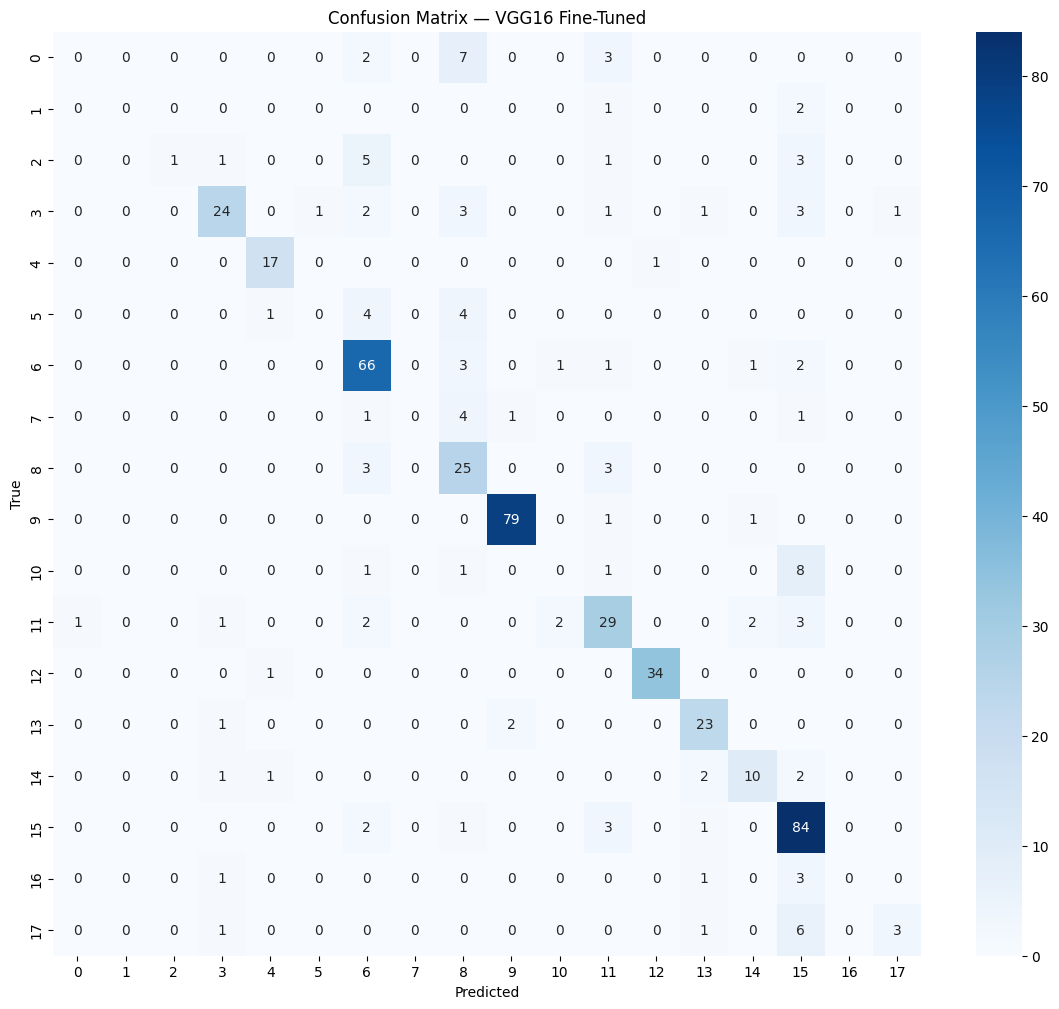

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# -----------------------------
# Confusion Matrix (VGG16 Fine-Tuned)
# -----------------------------
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)

plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix — VGG16 Fine-Tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# One-vs-Rest ROC Curves for VGG16 Fine-Tuned

17/17 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step


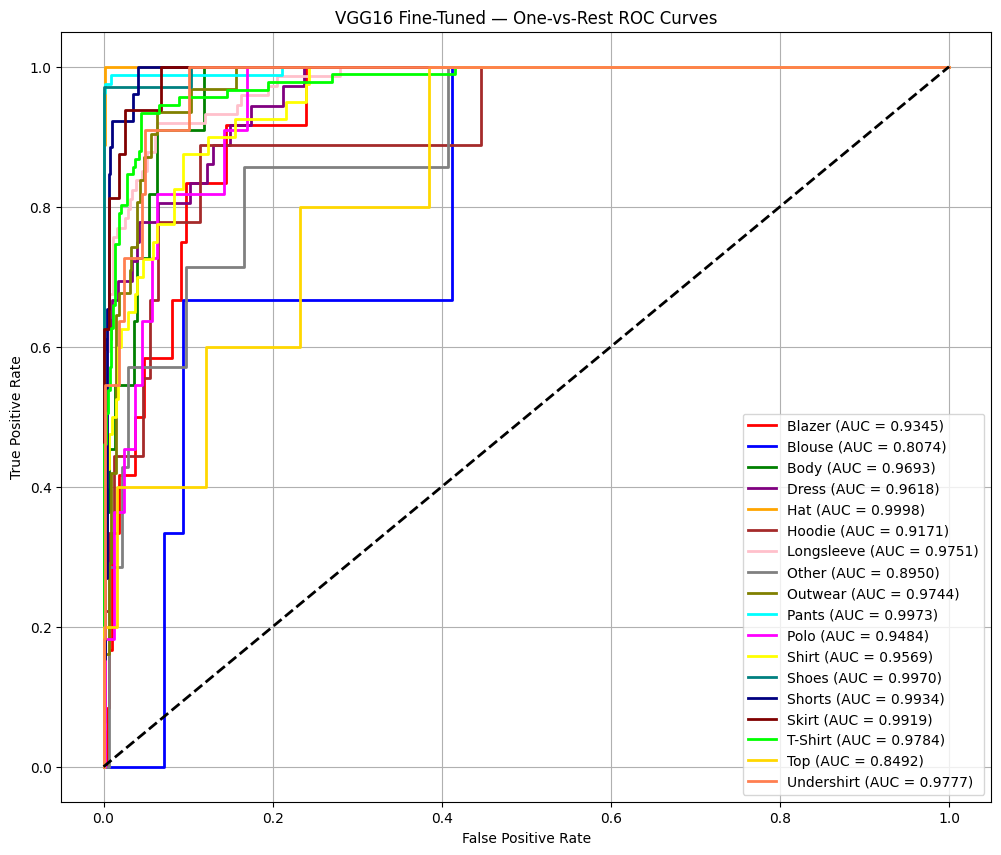


Per-class AUCs:
00 Blazer           AUC = 0.9344884488448846
01 Blouse           AUC = 0.8073929961089494
02 Body             AUC = 0.9692777578153072
03 Dress            AUC = 0.9618272118272118
04 Hat              AUC = 0.9997773324426631
05 Hoodie           AUC = 0.9171041119860017
06 Longsleeve       AUC = 0.9751387956805564
07 Other            AUC = 0.8949579831932772
08 Outwear          AUC = 0.9743793973184655
09 Pants            AUC = 0.9972533695775285
10 Polo             AUC = 0.9484369385555156
11 Shirt            AUC = 0.9569182389937108
12 Shoes            AUC = 0.997036158861885
13 Shorts           AUC = 0.9934200219332603
15 Skirt            AUC = 0.9918912175648702
16 T-Shirt          AUC = 0.9783831192281897
17 Top              AUC = 0.84921875
18 Undershirt       AUC = 0.9777218828602228


In [79]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# -----------------------------
# 1. Predict probabilities
# -----------------------------
steps = int(np.ceil(test_gen.samples / test_gen.batch_size))
y_probs = vgg16_ft.predict(test_gen, steps=steps)

# True labels
y_true = test_gen.classes

# -----------------------------
# 2. Binarize labels (One-vs-Rest)
# -----------------------------
n_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# -----------------------------
# 3. Compute ROC curves + AUC
# -----------------------------
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    # Only compute if class exists in test set
    if i in np.unique(y_true):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr[i], tpr[i], roc_auc[i] = None, None, None

# -----------------------------
# 4. Plot ROC Curves
# -----------------------------
plt.figure(figsize=(12, 10))

colors = cycle([
    "red", "blue", "green", "purple", "orange", "brown", "pink",
    "gray", "olive", "cyan", "magenta", "yellow", "teal",
    "navy", "maroon", "lime", "gold", "coral", "orchid"
])

class_labels = list(train_gen.class_indices.keys())

for i, color in zip(np.unique(y_true), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"{class_labels[i]} (AUC = {roc_auc[i]:.4f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("VGG16 Fine-Tuned — One-vs-Rest ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Print AUC values
# -----------------------------
print("\nPer-class AUCs:")
for i in np.unique(y_true):
    print(f"{i:02d} {class_labels[i]:15}  AUC = {roc_auc[i]}")


# MobileNetV2

# Build Image Generators for MobileNetV2 (MUST redo)

In [103]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen_mn = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen_mn = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

test_datagen_mn = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

classes_mn = list(train_gen.class_indices.keys())

train_gen_mn = train_datagen_mn.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    classes=classes_mn,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)

val_gen_mn = val_datagen_mn.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    classes=classes_mn,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen_mn = test_datagen_mn.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    classes=classes_mn,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 4136 validated image filenames belonging to 19 classes.
Found 517 validated image filenames belonging to 19 classes.
Found 517 validated image filenames belonging to 19 classes.


# Build MobileNetV2 Model (Frozen Layers)

In [104]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

num_classes = len(train_gen.class_indices)

mobilenet_base = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze feature extractor
for layer in mobilenet_base.layers:
    layer.trainable = False

model_mobilenet = models.Sequential([
    mobilenet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

model_mobilenet.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,590,803 (9.88 MB)

 Trainable params: 332,819 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Compile the Model

In [105]:
from tensorflow.keras.optimizers import Adam

model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train MobileNetV2 (Frozen)

In [106]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_mn = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_mobilenetv2.h5", monitor="val_loss", save_best_only=True, verbose=1)
]

history_mobilenet = model_mobilenet.fit(
    train_gen_mn,
    validation_data=val_gen_mn,
    epochs=20,
    callbacks=callbacks_mn,
    verbose=1
)


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.2644 - loss: 2.5807
Epoch 1: val_loss improved from None to 1.52518, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 102s 753ms/step - accuracy: 0.3774 - loss: 2.1995 - val_accuracy: 0.6074 - val_loss: 1.5252 - learning_rate: 1.0000e-04
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.5595 - loss: 1.5492
Epoch 2: val_loss improved from 1.52518 to 1.18629, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 739ms/step - accuracy: 0.5798 - loss: 1.4723 - val_accuracy: 0.6712 - val_loss: 1.1863 - learning_rate: 1.0000e-04
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6234 - loss: 1.2847
Epoch 3: val_loss improved from 1.18629 to 1.03300, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 748ms/step - accuracy: 0.6342 - loss: 1.2429 - val_accuracy: 0.6983 - val_loss: 1.0330 - learning_rate: 1.0000e-04
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.6667 - loss: 1.1229
Epoch 4: val_loss improved from 1.03300 to 0.94451, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 99s 758ms/step - accuracy: 0.6705 - loss: 1.0979 - val_accuracy: 0.7350 - val_loss: 0.9445 - learning_rate: 1.0000e-04
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.7041 - loss: 1.0261
Epoch 5: val_loss improved from 0.94451 to 0.88568, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 98s 751ms/step - accuracy: 0.7036 - loss: 0.9972 - val_accuracy: 0.7408 - val_loss: 0.8857 - learning_rate: 1.0000e-04
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.7135 - loss: 0.9441
Epoch 6: val_loss improved from 0.88568 to 0.84719, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 741ms/step - accuracy: 0.7212 - loss: 0.9242 - val_accuracy: 0.7544 - val_loss: 0.8472 - learning_rate: 1.0000e-04
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.7372 - loss: 0.8746
Epoch 7: val_loss improved from 0.84719 to 0.81133, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 743ms/step - accuracy: 0.7360 - loss: 0.8807 - val_accuracy: 0.7660 - val_loss: 0.8113 - learning_rate: 1.0000e-04
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.7429 - loss: 0.8448
Epoch 8: val_loss improved from 0.81133 to 0.78849, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 98s 757ms/step - accuracy: 0.7418 - loss: 0.8342 - val_accuracy: 0.7756 - val_loss: 0.7885 - learning_rate: 1.0000e-04
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7625 - loss: 0.7707
Epoch 9: val_loss improved from 0.78849 to 0.76698, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 737ms/step - accuracy: 0.7522 - loss: 0.7881 - val_accuracy: 0.7756 - val_loss: 0.7670 - learning_rate: 1.0000e-04
Epoch 10/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.7631 - loss: 0.7713
Epoch 10: val_loss improved from 0.76698 to 0.75218, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 740ms/step - accuracy: 0.7623 - loss: 0.7619 - val_accuracy: 0.7872 - val_loss: 0.7522 - learning_rate: 1.0000e-04
Epoch 11/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7722 - loss: 0.7287
Epoch 11: val_loss improved from 0.75218 to 0.74106, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 739ms/step - accuracy: 0.7742 - loss: 0.7207 - val_accuracy: 0.7853 - val_loss: 0.7411 - learning_rate: 1.0000e-04
Epoch 12/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.7926 - loss: 0.6854
Epoch 12: val_loss improved from 0.74106 to 0.73365, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 740ms/step - accuracy: 0.7935 - loss: 0.6831 - val_accuracy: 0.7892 - val_loss: 0.7337 - learning_rate: 1.0000e-04
Epoch 13/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.7928 - loss: 0.6439
Epoch 13: val_loss improved from 0.73365 to 0.71589, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 746ms/step - accuracy: 0.7906 - loss: 0.6631 - val_accuracy: 0.7930 - val_loss: 0.7159 - learning_rate: 1.0000e-04
Epoch 14/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.8018 - loss: 0.6301
Epoch 14: val_loss improved from 0.71589 to 0.70680, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 736ms/step - accuracy: 0.7918 - loss: 0.6591 - val_accuracy: 0.7930 - val_loss: 0.7068 - learning_rate: 1.0000e-04
Epoch 15/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.7986 - loss: 0.6246
Epoch 15: val_loss improved from 0.70680 to 0.70215, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 97s 743ms/step - accuracy: 0.7969 - loss: 0.6303 - val_accuracy: 0.7988 - val_loss: 0.7021 - learning_rate: 1.0000e-04
Epoch 16/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.8031 - loss: 0.6299
Epoch 16: val_loss improved from 0.70215 to 0.68881, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 740ms/step - accuracy: 0.8083 - loss: 0.6199 - val_accuracy: 0.7969 - val_loss: 0.6888 - learning_rate: 1.0000e-04
Epoch 17/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.7952 - loss: 0.6249
Epoch 17: val_loss did not improve from 0.68881
130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 741ms/step - accuracy: 0.8037 - loss: 0.6057 - val_accuracy: 0.7930 - val_loss: 0.6927 - learning_rate: 1.0000e-04
Epoch 18/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8171 - loss: 0.5669
Epoch 18: val_loss improved from 0.68881 to 0.68155, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 741ms/step - accuracy: 0.8117 - loss: 0.5826 - val_accuracy: 0.8027 - val_loss: 0.6816 - learning_rate: 1.0000e-04
Epoch 19/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.8230 - loss: 0.5610
Epoch 19: val_loss improved from 0.68155 to 0.66992, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 96s 740ms/step - accuracy: 0.8288 - loss: 0.5523 - val_accuracy: 0.8066 - val_loss: 0.6699 - learning_rate: 1.0000e-04
Epoch 20/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.8237 - loss: 0.5378
Epoch 20: val_loss improved from 0.66992 to 0.66858, saving model to best_mobilenetv2.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 94s 719ms/step - accuracy: 0.8247 - loss: 0.5499 - val_accuracy: 0.8027 - val_loss: 0.6686 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


# Evaluate on Test Set

In [107]:
from tensorflow.keras.models import load_model

mobilenet_best = load_model("best_mobilenetv2.h5")

test_loss, test_acc = mobilenet_best.evaluate(test_gen_mn, verbose=1)

print("MobileNetV2 Frozen — Test Accuracy:", test_acc)
print("MobileNetV2 Frozen — Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 698ms/step - accuracy: 0.8085 - loss: 0.6641
MobileNetV2 Frozen — Test Accuracy: 0.8085106611251831
MobileNetV2 Frozen — Test Loss: 0.6640535593032837


# MobileNetV2 Fine-Tuning

### Load the Best Frozen MobileNetV2 Model

In [108]:
from tensorflow.keras.models import load_model

# Load the best frozen MobileNetV2 model
mobilenet_ft = load_model("best_mobilenetv2.h5")

mobilenet_ft.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,590,805 (9.88 MB)

 Trainable params: 332,819 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

# Unfreeze Top Layers for Fine-Tuning

In [109]:
# Extract the MobileNetV2 base
mobilenet_base = mobilenet_ft.layers[0]   # This is the MobileNetV2 backbone

# Unfreeze last 40 layers for fine-tuning
for layer in mobilenet_base.layers[-40:]:
    layer.trainable = True

mobilenet_ft.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,590,805 (9.88 MB)

 Trainable params: 2,014,355 (7.68 MB)

 Non-trainable params: 576,448 (2.20 MB)

 Optimizer params: 2 (12.00 B)

# Recompile With a Very Small Learning Rate

In [110]:
from tensorflow.keras.optimizers import Adam

mobilenet_ft.compile(
    optimizer=Adam(learning_rate=1e-5),   # very small LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Fine-Tuning Callbacks

In [111]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_mn_ft = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", patience=2, factor=0.5, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_mobilenetv2_finetuned.h5", monitor="val_loss", save_best_only=True, verbose=1)
]


# Train (Fine-Tune) MobileNetV2

In [112]:
history_mobilenet_ft = mobilenet_ft.fit(
    train_gen_resnet,
    validation_data=val_gen_resnet,
    epochs=10,
    callbacks=callbacks_mn_ft,
    verbose=1
)


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 801ms/step - accuracy: 0.3720 - loss: 2.3066
Epoch 1: val_loss improved from None to 1.64924, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 122s 881ms/step - accuracy: 0.4062 - loss: 2.1240 - val_accuracy: 0.5203 - val_loss: 1.6492 - learning_rate: 1.0000e-05
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.4950 - loss: 1.7342
Epoch 2: val_loss improved from 1.64924 to 1.49721, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 116s 893ms/step - accuracy: 0.5063 - loss: 1.6844 - val_accuracy: 0.5667 - val_loss: 1.4972 - learning_rate: 1.0000e-05
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 878ms/step - accuracy: 0.5332 - loss: 1.5233
Epoch 3: val_loss improved from 1.49721 to 1.40135, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 126s 965ms/step - accuracy: 0.5293 - loss: 1.5446 - val_accuracy: 0.5861 - val_loss: 1.4014 - learning_rate: 1.0000e-05
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.5516 - loss: 1.4376
Epoch 4: val_loss improved from 1.40135 to 1.34328, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 110s 846ms/step - accuracy: 0.5660 - loss: 1.4197 - val_accuracy: 0.5957 - val_loss: 1.3433 - learning_rate: 1.0000e-05
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.5779 - loss: 1.3864
Epoch 5: val_loss improved from 1.34328 to 1.30629, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 114s 876ms/step - accuracy: 0.5832 - loss: 1.3555 - val_accuracy: 0.6093 - val_loss: 1.3063 - learning_rate: 1.0000e-05
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6252 - loss: 1.2510
Epoch 6: val_loss improved from 1.30629 to 1.28267, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 110s 848ms/step - accuracy: 0.6112 - loss: 1.2732 - val_accuracy: 0.6325 - val_loss: 1.2827 - learning_rate: 1.0000e-05
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.6129 - loss: 1.2270
Epoch 7: val_loss improved from 1.28267 to 1.24804, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 112s 860ms/step - accuracy: 0.6187 - loss: 1.2297 - val_accuracy: 0.6325 - val_loss: 1.2480 - learning_rate: 1.0000e-05
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 791ms/step - accuracy: 0.6295 - loss: 1.1663
Epoch 8: val_loss improved from 1.24804 to 1.22393, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 112s 859ms/step - accuracy: 0.6342 - loss: 1.1585 - val_accuracy: 0.6460 - val_loss: 1.2239 - learning_rate: 1.0000e-05
Epoch 9/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.6658 - loss: 1.1046
Epoch 9: val_loss improved from 1.22393 to 1.21344, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 114s 874ms/step - accuracy: 0.6559 - loss: 1.1174 - val_accuracy: 0.6383 - val_loss: 1.2134 - learning_rate: 1.0000e-05
Epoch 10/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.6472 - loss: 1.1261
Epoch 10: val_loss improved from 1.21344 to 1.18951, saving model to best_mobilenetv2_finetuned.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 112s 862ms/step - accuracy: 0.6642 - loss: 1.0902 - val_accuracy: 0.6325 - val_loss: 1.1895 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 10.


# Evaluate the Fine-Tuned Model

In [113]:
mobilenet_ft_best = load_model("best_mobilenetv2_finetuned.h5")

test_loss, test_acc = mobilenet_ft_best.evaluate(test_gen_resnet, verbose=1)

print("MobileNetV2 Fine-Tuned — Test Accuracy:", test_acc)
print("MobileNetV2 Fine-Tuned — Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 642ms/step - accuracy: 0.6847 - loss: 1.0146
MobileNetV2 Fine-Tuned — Test Accuracy: 0.6847195625305176
MobileNetV2 Fine-Tuned — Test Loss: 1.0146379470825195


# Classification Report + Confusion Matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 692ms/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      Blazer       0.33      0.17      0.22        12
      Blouse       0.00      0.00      0.00         3
        Body       0.67      0.18      0.29        11
       Dress       0.71      0.47      0.57        36
         Hat       1.00      0.56      0.71        18
      Hoodie       0.67      0.22      0.33         9
  Longsleeve       0.56      0.80      0.66        74
       Other       0.00      0.00      0.00         7
     Outwear       0.56      0.61      0.58        31
       Pants       0.95      0.90      0.92        81
        Polo       0.40      0.18      0.25        11
       Shirt       0.52      0.65      0.58        40
       Shoes       1.00      0.97      0.99        35
      Shorts       0.46      0.88      0.61        26
       Skirt       0.80      0.50      0.62        16
     T-Shirt       0.74      0.80      0.77        91
         Top  

d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

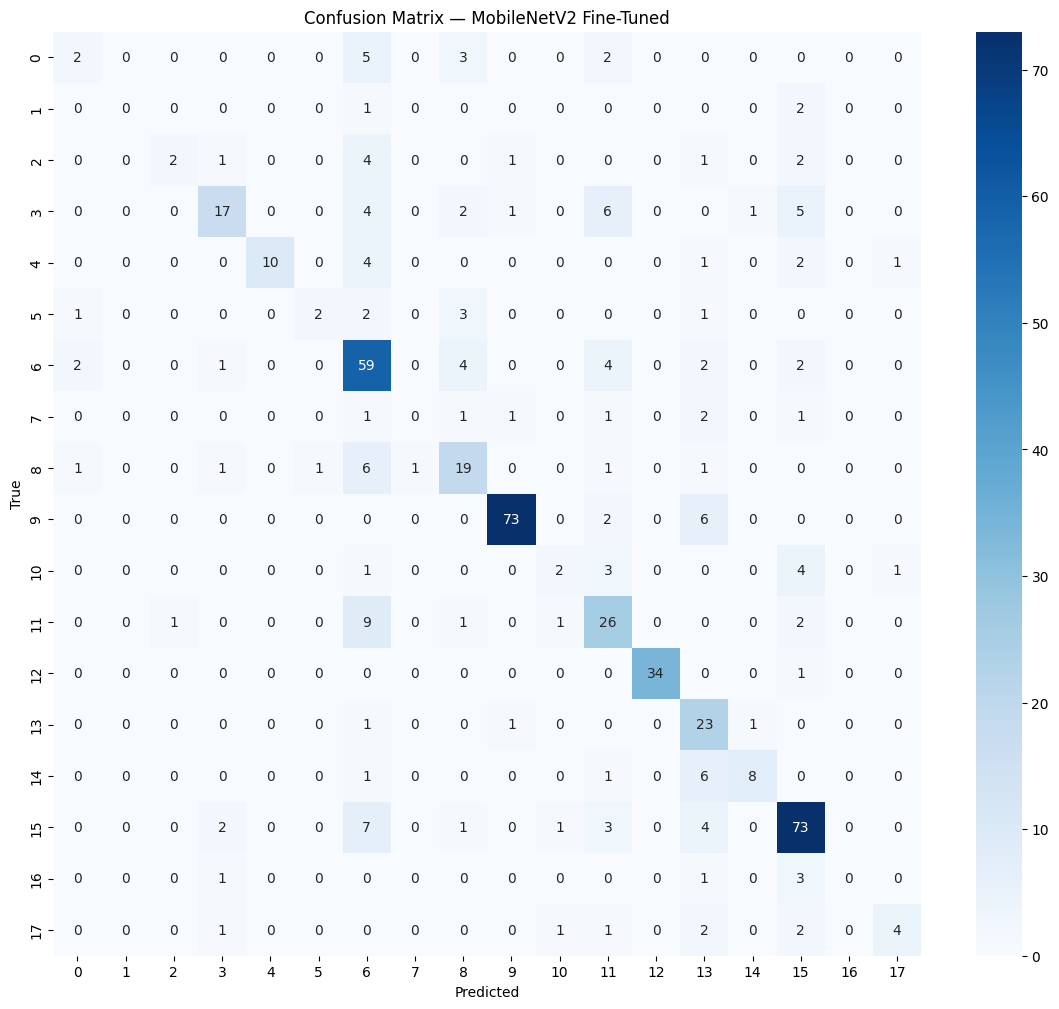

In [114]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

steps = int(np.ceil(test_gen_resnet.samples / test_gen_resnet.batch_size))
y_probs = mobilenet_ft_best.predict(test_gen_resnet, steps=steps)
y_pred = np.argmax(y_probs, axis=1)

y_true = test_gen_resnet.classes
class_labels = list(train_gen_resnet.class_indices.keys())

unique_classes = np.unique(y_true)
unique_class_names = [class_labels[i] for i in unique_classes]

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=unique_classes,
    target_names=unique_class_names
))

cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=True, cmap="Blues")
plt.title("Confusion Matrix — MobileNetV2 Fine-Tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# One-vs-Rest ROC Curves (Matching Your Format)

17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 588ms/step


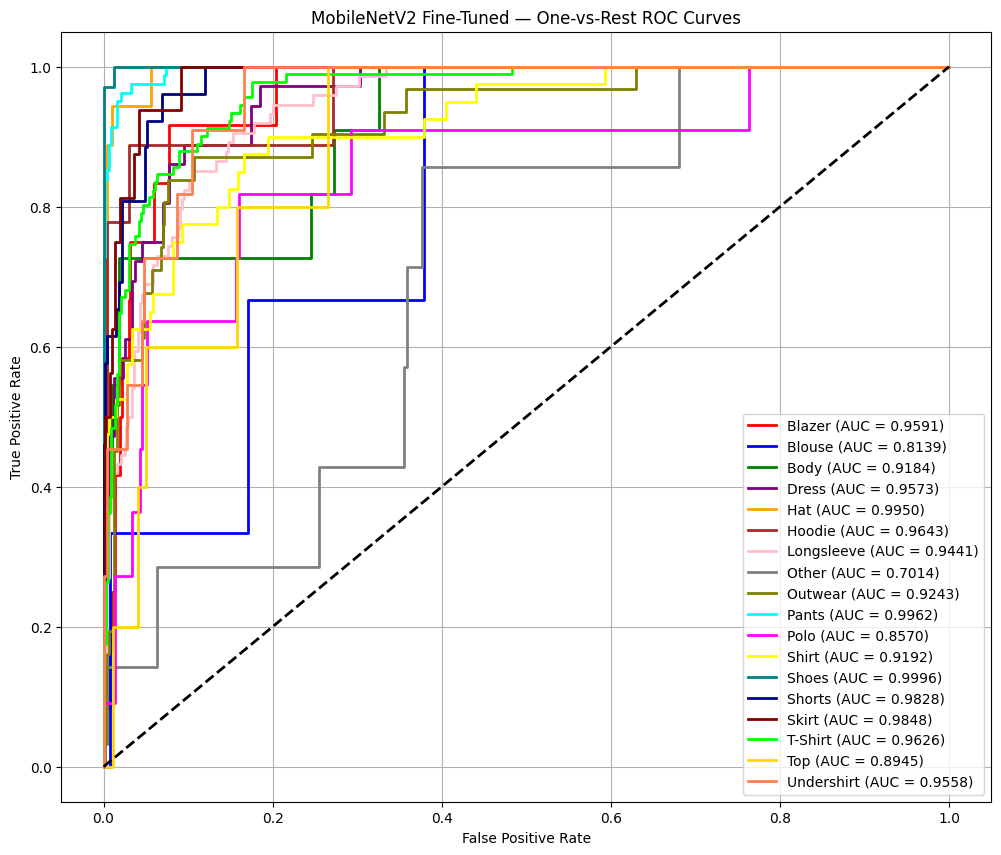


Per-class AUCs:
00 Blazer           AUC = 0.9590759075907591
01 Blouse           AUC = 0.8138780804150454
02 Body             AUC = 0.9184333453108157
03 Dress            AUC = 0.9572649572649572
04 Hat              AUC = 0.9949899799599198
05 Hoodie           AUC = 0.9643482064741907
06 Longsleeve       AUC = 0.9441156732353121
07 Other            AUC = 0.7014005602240896
08 Outwear          AUC = 0.9242665604672773
09 Pants            AUC = 0.996177370030581
10 Polo             AUC = 0.85698886094143
11 Shirt            AUC = 0.9191823899371069
12 Shoes            AUC = 0.9996443390634262
13 Shorts           AUC = 0.9827667241109196
15 Skirt            AUC = 0.9847804391217565
16 T-Shirt          AUC = 0.962570293556209
17 Top              AUC = 0.89453125
18 Undershirt       AUC = 0.955803090190442


In [115]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

# -----------------------------
# 1. Predict probabilities
# -----------------------------
steps = int(np.ceil(test_gen_resnet.samples / test_gen_resnet.batch_size))
y_probs = mobilenet_ft_best.predict(test_gen_resnet, steps=steps)

# True labels
y_true = test_gen_resnet.classes

# -----------------------------
# 2. Binarize labels
# -----------------------------
n_classes = y_probs.shape[1]
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# -----------------------------
# 3. Compute ROC + AUC
# -----------------------------
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    if i in np.unique(y_true):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr[i], tpr[i], roc_auc[i] = None, None, None

# -----------------------------
# 4. Plot
# -----------------------------
plt.figure(figsize=(12, 10))

colors = cycle([
    "red","blue","green","purple","orange","brown","pink","gray","olive","cyan",
    "magenta","yellow","teal","navy","maroon","lime","gold","coral","orchid"
])

class_labels = list(train_gen_resnet.class_indices.keys())

for i, color in zip(np.unique(y_true), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"{class_labels[i]} (AUC = {roc_auc[i]:.4f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MobileNetV2 Fine-Tuned — One-vs-Rest ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# -----------------------------
# 5. Print AUCs
# -----------------------------
print("\nPer-class AUCs:")
for i in np.unique(y_true):
    print(f"{i:02d} {class_labels[i]:15}  AUC = {roc_auc[i]}")


# EfficientNetB0 (Frozen)

# Import & Build EfficientNetB0 Base (Frozen)

In [116]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

num_classes = len(classes_resnet)

# Load EfficientNetB0 base
efficient_base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze all layers
for layer in efficient_base.layers:
    layer.trainable = False

# Build model
efficient_model = models.Sequential([
    efficient_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

efficient_model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 66s 4us/step


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,382,390 (16.72 MB)

 Trainable params: 332,819 (1.27 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Compile the Frozen Model

In [117]:
from tensorflow.keras.optimizers import Adam

efficient_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Callbacks

In [118]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_ef = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint("best_efficientnetb0.h5", monitor="val_loss", save_best_only=True, verbose=1)
]


# Train EfficientNetB0 (Frozen)

In [119]:
history_efficient_frozen = efficient_model.fit(
    train_gen_resnet,
    validation_data=val_gen_resnet,
    epochs=20,
    callbacks=callbacks_ef,
    verbose=1
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - accuracy: 0.2154 - loss: 2.6490
Epoch 1: val_loss improved from None to 1.80082, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.3221 - loss: 2.3615 - val_accuracy: 0.4913 - val_loss: 1.8008 - learning_rate: 1.0000e-04
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.4607 - loss: 1.9018
Epoch 2: val_loss improved from 1.80082 to 1.49401, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.4746 - loss: 1.8413 - val_accuracy: 0.5764 - val_loss: 1.4940 - learning_rate: 1.0000e-04
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5141 - loss: 1.6734
Epoch 3: val_loss improved from 1.49401 to 1.30830, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.5368 - loss: 1.6124 - val_accuracy: 0.6267 - val_loss: 1.3083 - learning_rate: 1.0000e-04
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 966ms/step - accuracy: 0.5738 - loss: 1.5018
Epoch 4: val_loss improved from 1.30830 to 1.20223, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5779 - loss: 1.4667 - val_accuracy: 0.6402 - val_loss: 1.2022 - learning_rate: 1.0000e-04
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 899ms/step - accuracy: 0.5929 - loss: 1.4120
Epoch 5: val_loss improved from 1.20223 to 1.12719, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 129s 988ms/step - accuracy: 0.6040 - loss: 1.3775 - val_accuracy: 0.6596 - val_loss: 1.1272 - learning_rate: 1.0000e-04
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 795ms/step - accuracy: 0.6124 - loss: 1.3045
Epoch 6: val_loss improved from 1.12719 to 1.06877, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 115s 882ms/step - accuracy: 0.6233 - loss: 1.2936 - val_accuracy: 0.6673 - val_loss: 1.0688 - learning_rate: 1.0000e-04
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.6473 - loss: 1.2139
Epoch 7: val_loss improved from 1.06877 to 1.03451, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 118s 906ms/step - accuracy: 0.6368 - loss: 1.2342 - val_accuracy: 0.6867 - val_loss: 1.0345 - learning_rate: 1.0000e-04
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.6346 - loss: 1.2069
Epoch 8: val_loss improved from 1.03451 to 0.99977, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 118s 908ms/step - accuracy: 0.6366 - loss: 1.2054 - val_accuracy: 0.7021 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 9/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6450 - loss: 1.1450
Epoch 9: val_loss improved from 0.99977 to 0.98330, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 118s 903ms/step - accuracy: 0.6506 - loss: 1.1504 - val_accuracy: 0.7021 - val_loss: 0.9833 - learning_rate: 1.0000e-04
Epoch 10/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.6566 - loss: 1.1381
Epoch 10: val_loss improved from 0.98330 to 0.96678, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 118s 906ms/step - accuracy: 0.6651 - loss: 1.1094 - val_accuracy: 0.7041 - val_loss: 0.9668 - learning_rate: 1.0000e-04
Epoch 11/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.6779 - loss: 1.0436
Epoch 11: val_loss improved from 0.96678 to 0.94016, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 117s 899ms/step - accuracy: 0.6690 - loss: 1.0801 - val_accuracy: 0.7176 - val_loss: 0.9402 - learning_rate: 1.0000e-04
Epoch 12/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.6731 - loss: 1.0690
Epoch 12: val_loss improved from 0.94016 to 0.93201, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 116s 893ms/step - accuracy: 0.6714 - loss: 1.0774 - val_accuracy: 0.7215 - val_loss: 0.9320 - learning_rate: 1.0000e-04
Epoch 13/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 820ms/step - accuracy: 0.6785 - loss: 1.0448
Epoch 13: val_loss improved from 0.93201 to 0.91878, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 118s 909ms/step - accuracy: 0.6838 - loss: 1.0349 - val_accuracy: 0.7273 - val_loss: 0.9188 - learning_rate: 1.0000e-04
Epoch 14/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - accuracy: 0.6986 - loss: 0.9934
Epoch 14: val_loss improved from 0.91878 to 0.90859, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 119s 920ms/step - accuracy: 0.6963 - loss: 0.9976 - val_accuracy: 0.7234 - val_loss: 0.9086 - learning_rate: 1.0000e-04
Epoch 15/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.6880 - loss: 0.9903
Epoch 15: val_loss improved from 0.90859 to 0.89853, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 117s 900ms/step - accuracy: 0.6881 - loss: 1.0006 - val_accuracy: 0.7389 - val_loss: 0.8985 - learning_rate: 1.0000e-04
Epoch 16/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.7010 - loss: 0.9757
Epoch 16: val_loss improved from 0.89853 to 0.89091, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 116s 893ms/step - accuracy: 0.7029 - loss: 0.9788 - val_accuracy: 0.7350 - val_loss: 0.8909 - learning_rate: 1.0000e-04
Epoch 17/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 818ms/step - accuracy: 0.7043 - loss: 0.9516
Epoch 17: val_loss improved from 0.89091 to 0.89086, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 118s 905ms/step - accuracy: 0.7041 - loss: 0.9505 - val_accuracy: 0.7331 - val_loss: 0.8909 - learning_rate: 1.0000e-04
Epoch 18/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.7052 - loss: 0.9309
Epoch 18: val_loss improved from 0.89086 to 0.87864, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 117s 900ms/step - accuracy: 0.7060 - loss: 0.9340 - val_accuracy: 0.7369 - val_loss: 0.8786 - learning_rate: 1.0000e-04
Epoch 19/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.7208 - loss: 0.9194
Epoch 19: val_loss improved from 0.87864 to 0.87612, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 120s 924ms/step - accuracy: 0.7116 - loss: 0.9388 - val_accuracy: 0.7408 - val_loss: 0.8761 - learning_rate: 1.0000e-04
Epoch 20/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 794ms/step - accuracy: 0.7309 - loss: 0.8894
Epoch 20: val_loss improved from 0.87612 to 0.87520, saving model to best_efficientnetb0.h5


130/130 ━━━━━━━━━━━━━━━━━━━━ 115s 882ms/step - accuracy: 0.7178 - loss: 0.9098 - val_accuracy: 0.7408 - val_loss: 0.8752 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 20.


# Evaluate on Test Set

In [120]:
from tensorflow.keras.models import load_model

efficient_best = load_model("best_efficientnetb0.h5")

test_loss, test_acc = efficient_best.evaluate(test_gen_resnet, verbose=1)

print("EfficientNetB0 Frozen — Test Accuracy:", test_acc)
print("EfficientNetB0 Frozen — Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.7505 - loss: 0.7693
EfficientNetB0 Frozen — Test Accuracy: 0.7504835724830627
EfficientNetB0 Frozen — Test Loss: 0.7692708969116211


# EfficientNetB0 Fine-Tuning

### Load Best Frozen Model

In [133]:
from tensorflow.keras.models import load_model

efficient_best = load_model("best_efficientnetb0.h5")
efficient_best.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 19)             │         4,883 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,382,392 (16.72 MB)

 Trainable params: 332,819 (1.27 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2 (12.00 B)

# Rebuild EfficientNetB0 in Functional API (Fixes Error)

In [134]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

num_classes = len(classes_resnet)

# Load backbone
efficient_base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Unfreeze last 50 layers for fine-tuning
for layer in efficient_base.layers[:-50]:
    layer.trainable = False
for layer in efficient_base.layers[-50:]:
    layer.trainable = True

# Functional model head
x = layers.GlobalAveragePooling2D()(efficient_base.output)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

efficient_ft = Model(inputs=efficient_base.input, outputs=outputs)


# Compile Model

In [135]:
efficient_ft.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


# Create Callbacks (SAFE VERSION)

In [137]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks_eff_ft = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        patience=2,
        factor=0.5,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        "best_efficientnetb0_finetuned.weights.h5",   # ← Correct extension
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,   # ← required to avoid deepcopy error
        verbose=1
    )
]


# Train EfficientNetB0 (Fine-Tuning)

In [138]:
# STEP E — Train EfficientNetB0 (Fine-Tuning)
history_efficient_ft = efficient_ft.fit(
    train_gen_resnet,
    validation_data=val_gen_resnet,
    epochs=10,
    callbacks=callbacks_eff_ft,
    verbose=1
)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0835 - loss: 2.9939
Epoch 1: val_loss improved from None to 2.77277, saving model to best_efficientnetb0_finetuned.weights.h5
130/130 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.0936 - loss: 2.9417 - val_accuracy: 0.1431 - val_loss: 2.7728 - learning_rate: 1.0000e-05
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1497 - loss: 2.7901
Epoch 2: val_loss improved from 2.77277 to 2.53724, saving model to best_efficientnetb0_finetuned.weights.h5
130/130 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.1700 - loss: 2.7472 - val_accuracy: 0.2959 - val_loss: 2.5372 - learning_rate: 1.0000e-05
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.2440 - loss: 2.6055
Epoch 3: val_loss improved from 2.53724 to 2.32087, saving model to best_efficientnetb0_finetuned.weights.h5
130/130 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.2684 - loss: 2.5540 - val_accuracy: 0.3791 - val_loss: 2.3209 - learni

# Load Best Fine-Tuned Weights

In [140]:
# STEP F — Load Best Fine-Tuned Weights
efficient_ft.load_weights("best_efficientnetb0_finetuned.weights.h5")
print("Best fine-tuned EfficientNetB0 weights loaded successfully.")


Best fine-tuned EfficientNetB0 weights loaded successfully.


# Evaluate Fine-Tuned Model on Test Set

In [141]:
# STEP G — Evaluate fine-tuned EfficientNetB0
test_loss, test_acc = efficient_ft.evaluate(test_gen_resnet, verbose=1)

print("EfficientNetB0 Fine-Tuned — Test Accuracy:", test_acc)
print("EfficientNetB0 Fine-Tuned — Test Loss:", test_loss)


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 716ms/step - accuracy: 0.6035 - loss: 1.4499
EfficientNetB0 Fine-Tuned — Test Accuracy: 0.603481650352478
EfficientNetB0 Fine-Tuned — Test Loss: 1.4499047994613647


# Classification Report + Confusion Matrix

17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 799ms/step

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

      Blazer       0.00      0.00      0.00        12
      Blouse       0.00      0.00      0.00         3
        Body       0.00      0.00      0.00        11
       Dress       0.52      0.36      0.43        36
         Hat       1.00      0.17      0.29        18
      Hoodie       0.00      0.00      0.00         9
  Longsleeve       0.42      0.84      0.56        74
       Other       0.00      0.00      0.00         7
     Outwear       0.67      0.06      0.12        31
       Pants       0.88      0.95      0.91        81
        Polo       0.00      0.00      0.00        11
       Shirt       0.54      0.70      0.61        40
       Shoes       0.71      0.97      0.82        35
      Shorts       0.73      0.42      0.54        26
       Skirt       0.00      0.00      0.00        16
     T-Shirt       0.61      0.90      0.73        91
         Top  

d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Data_science\Capstone Project 2 File\myenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

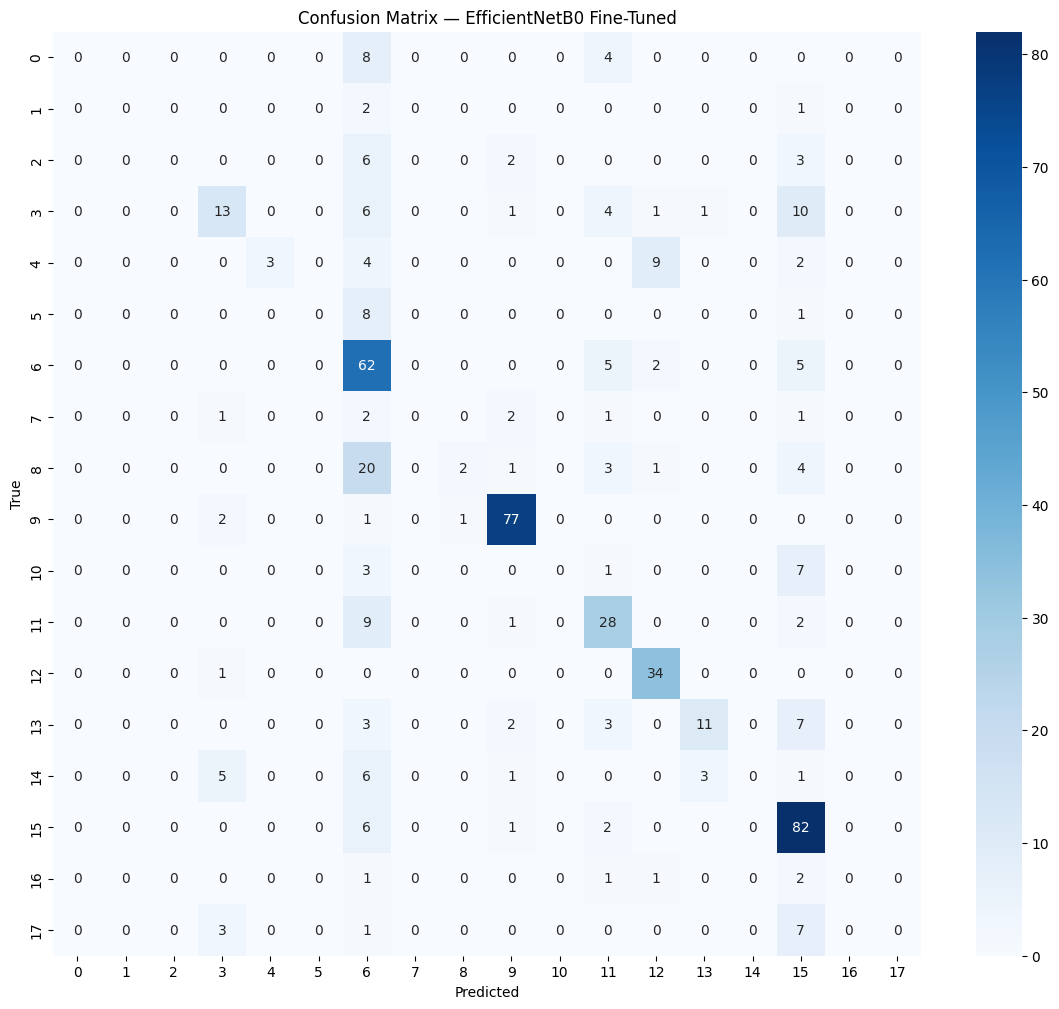

In [142]:
# STEP H — Classification Report & Confusion Matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

steps = int(np.ceil(test_gen_resnet.samples / test_gen_resnet.batch_size))
y_probs = efficient_ft.predict(test_gen_resnet, steps=steps)
y_pred = np.argmax(y_probs, axis=1)
y_true = test_gen_resnet.classes

class_labels = list(classes_resnet)

# Only include classes that appear in the test set
unique_classes = np.unique(y_true)
unique_class_names = [class_labels[i] for i in unique_classes]

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(
    y_true,
    y_pred,
    labels=unique_classes,
    target_names=unique_class_names
))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=unique_classes)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix — EfficientNetB0 Fine-Tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


# One-vs-Rest ROC Curves + AUC

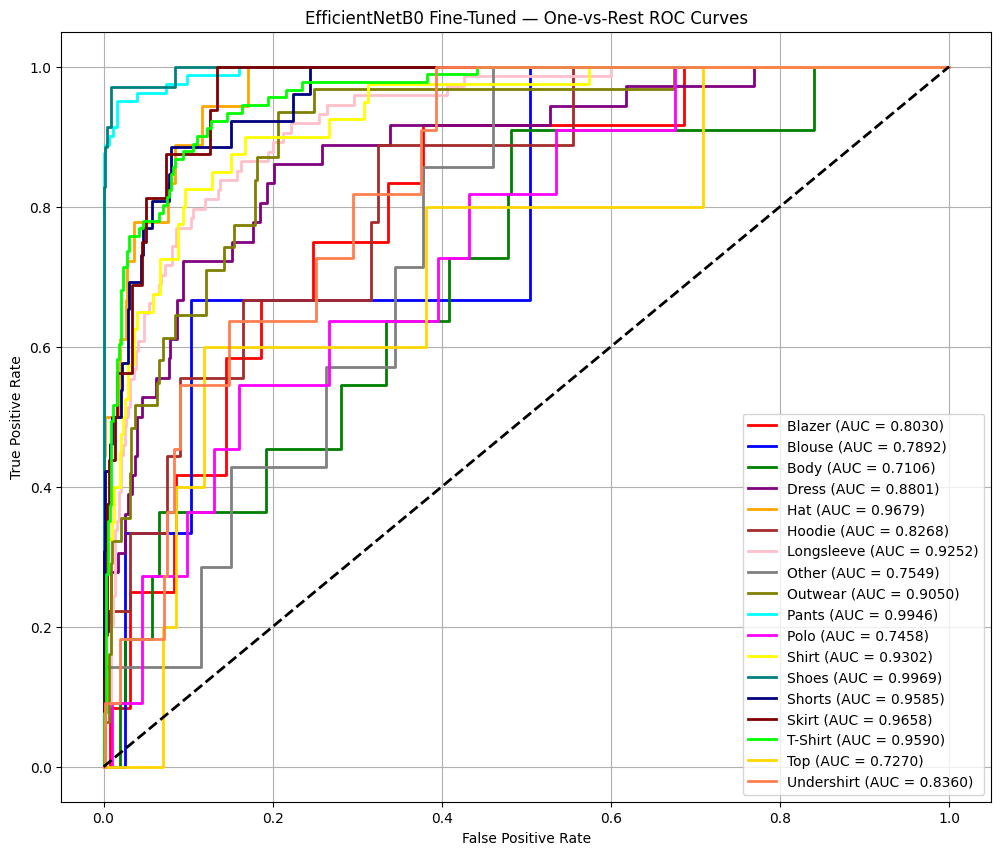


Per-class AUCs:
00 Blazer           AUC = 0.802970297029703
01 Blouse           AUC = 0.7892347600518806
02 Body             AUC = 0.7105641394178943
03 Dress            AUC = 0.8800531300531299
04 Hat              AUC = 0.9679358717434869
05 Hoodie           AUC = 0.8267716535433071
06 Longsleeve       AUC = 0.9252333597706057
07 Other            AUC = 0.7549019607843137
08 Outwear          AUC = 0.9049515465286074
09 Pants            AUC = 0.9945633707101597
10 Polo             AUC = 0.7457779374775422
11 Shirt            AUC = 0.9302410901467505
12 Shoes            AUC = 0.9968583283935981
13 Shorts           AUC = 0.958483471721761
15 Skirt            AUC = 0.9658183632734532
16 T-Shirt          AUC = 0.9590104730949802
17 Top              AUC = 0.726953125
18 Undershirt       AUC = 0.8359683794466404


In [143]:
# STEP I — ROC-AUC Curves for EfficientNetB0 Fine-Tuned
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# True labels
y_true = test_gen_resnet.classes

# Binarize labels
n_classes = len(class_labels)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Compute ROC + AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    if i in np.unique(y_true):  # only compute classes present in test set
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    else:
        fpr[i], tpr[i], roc_auc[i] = None, None, None

# Plot ROC
plt.figure(figsize=(12, 10))
colors = cycle([
    "red", "blue", "green", "purple", "orange", "brown", "pink", "gray",
    "olive", "cyan", "magenta", "yellow", "teal", "navy", "maroon",
    "lime", "gold", "coral", "orchid"
])

for i, color in zip(np.unique(y_true), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        color=color,
        label=f"{class_labels[i]} (AUC = {roc_auc[i]:.4f})"
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientNetB0 Fine-Tuned — One-vs-Rest ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC values
print("\nPer-class AUCs:")
for i in np.unique(y_true):
    print(f"{i:02d} {class_labels[i]:15}  AUC = {roc_auc[i]}")


# Comparison Table Code (clean + correct)

In [144]:
import pandas as pd

# ---- Enter your model performance here ----
data = {
    "Model": [
        "CNN Scratch",
        "ResNet50 Frozen",
        "ResNet50 Fine-Tuned",
        "VGG16 Frozen",
        "VGG16 Fine-Tuned",
        "MobileNetV2 Frozen",
        "MobileNetV2 Fine-Tuned",
        "EfficientNetB0 Frozen",
        "EfficientNetB0 Fine-Tuned"
    ],
    
    "Test Accuracy": [
        0.7021276354789734,
        0.3133462369441986,
        0.8181818127632141,
        0.5164409875869751,
        0.7640231847763062,
        0.8085106611251831,
        0.6847195625305176,
        0.7504835724830627,
        0.603481650352478
    ],

    "Test Loss": [
        1.0987504720687866,
        2.279540777206421,
        0.7276885509490967,
        1.7240118980407715,
        0.8267384171485901,
        0.6640535593032837,
        1.0146379470825195,
        0.7692708969116211,
        1.4499047994613647
    ],
}

# ---- Create DataFrame ----
df = pd.DataFrame(data)

# ---- Sort by accuracy (descending) ----
df_sorted = df.sort_values(by="Test Accuracy", ascending=False)

# ---- Display ----
df_sorted.reset_index(drop=True)


,Model,Test Accuracy,Test Loss
0,ResNet50 Fine-Tuned,0.818182,0.727689
1,MobileNetV2 Frozen,0.808511,0.664054
2,VGG16 Fine-Tuned,0.764023,0.826738
3,EfficientNetB0 Frozen,0.750484,0.769271
4,CNN Scratch,0.702128,1.098750
5,MobileNetV2 Fine-Tuned,0.684720,1.014638
6,EfficientNetB0 Fine-Tuned,0.603482,1.449905
7,VGG16 Frozen,0.516441,1.724012
8,ResNet50 Frozen,0.313346,2.279541


# Visualization

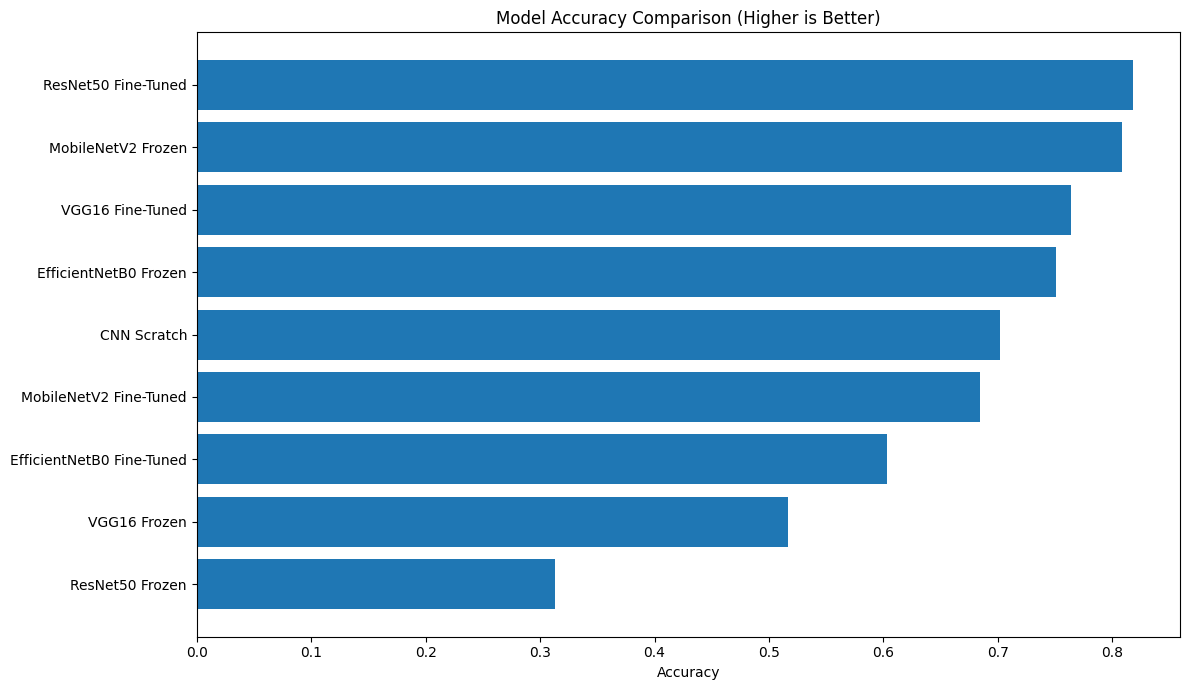

In [145]:
import matplotlib.pyplot as plt

# Model performance dict
models = {
    "ResNet50 Fine-Tuned": 0.8181818127632141,
    "MobileNetV2 Frozen": 0.8085106611251831,
    "VGG16 Fine-Tuned": 0.7640231847763062,
    "EfficientNetB0 Frozen": 0.7504835724830627,
    "CNN Scratch": 0.7021276354789734,
    "MobileNetV2 Fine-Tuned": 0.6847195625305176,
    "VGG16 Frozen": 0.5164409875869751,
    "EfficientNetB0 Fine-Tuned": 0.603481650352478,
    "ResNet50 Frozen": 0.3133462369441986
}

# Sort models by accuracy
sorted_models = dict(sorted(models.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 7))
plt.barh(list(sorted_models.keys()), list(sorted_models.values()))
plt.xlabel("Accuracy")
plt.title("Model Accuracy Comparison (Higher is Better)")
plt.gca().invert_yaxis()  # Highest accuracy on top
plt.tight_layout()
plt.show()


# Saving the best-performing model, which is:

### ResNet50 Fine-Tuned — Test Accuracy: 0.81818

In [147]:
resnet_ft_best.save("final_clothing_classifier.keras")

# Create a class names file 

### Because my model uses 19 clothing classes in a fixed order, Streamlit must know the class labels.

In [148]:
import json

class_names = list(train_gen.class_indices.keys())

with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("Saved class_names.json")


Saved class_names.json
